Dataset: https://www.kaggle.com/datasets/fabrizioravelli/retinal-oct-images-splitted/

In [ ]:
!pip install tensorflow==2.15.0

##Import

In [ ]:
import os
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
# import tqdm
from tqdm.notebook import tqdm
from tqdm.notebook import trange
# #---------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
#---------------------------------------
import tensorflow as tf
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#---------------------------------------
import warnings
warnings.filterwarnings("ignore")
from gc import collect
from joblib import Parallel, delayed
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from numpy import savetxt
from numpy import genfromtxt
tf.__version__

'2.15.0'

##Prepare Load

In [ ]:
def full_df(df_path):
    classes = []
    class_paths = []
    files = os.listdir(df_path)
    for file in files:
        label_dir = os.path.join(df_path, file)
        label = os.listdir(label_dir)
        for image in label:
            image_path = os.path.join(label_dir, image)
            class_paths.append(image_path)
            classes.append(file)
    image_classes = pd.Series(classes, name='Class')
    image_paths = pd.Series(class_paths, name='Class Path')
    df = pd.concat([image_paths, image_classes], axis=1)
    return df

def part_df(df_path):
    import random
    classes = []
    class_paths = []
    class_counts = {}
    files = os.listdir(df_path)
    random.shuffle(files)
    for file in files:
        label_dir = os.path.join(df_path, file)
        label = os.listdir(label_dir)
        class_counts[file] = 0
        for image in label:
            if class_counts[file] >= 1000:
                break
            image_path = os.path.join(label_dir, image)
            class_paths.append(image_path)
            classes.append(file)
            class_counts[file] += 1
    image_classes = pd.Series(classes, name='Class')
    image_paths = pd.Series(class_paths, name='Class Path')
    df = pd.concat([image_paths, image_classes], axis=1)
    return df

In [ ]:
ts_df = full_df('C:/Users/User/Downloads/archive/test')
vld_df = full_df('C:/Users/User/Downloads/archive/training/val')
tr_df = part_df('C:/Users/User/Downloads/archive/training/train')

In [ ]:
def form_x(i):
    im = tf.math.reduce_mean(cv2.imread(tr_df['Class Path'][i]), axis=2, keepdims=True)
    im = tf.image.resize_with_pad(im,target_height=496,target_width=512)
    return im.numpy().astype(np.ubyte)
def form_y(i):
    return tr_df['Class'][i]

x_train = []
for i in tqdm(range(len(tr_df))):
    x_train.append(form_x(i))

# A faster alternative, but it sometimes fails
# x_train = Parallel(n_jobs=16)(delayed(form_x)(i) for i in tqdm(range(len(tr_df))))
# y_train = Parallel(n_jobs=16)(delayed(form_y)(i) for i in tqdm(range(len(tr_df))))

  0%|          | 0/4000 [00:00<?, ?it/s]

In [ ]:
y_train = []
for i in tqdm(range(len(tr_df))):
    y_train.append(tr_df['Class'][i])

  0%|          | 0/4000 [00:00<?, ?it/s]

In [ ]:
x_train_np = np.array(x_train)
y_train_np = np.array(y_train)

In [ ]:
x_train_np.shape, y_train_np.shape

((4000, 496, 512, 1), (4000,))

In [ ]:
le = LabelEncoder()
le.fit(y_train_np)
le.classes_ = le.classes_[::-1]
y_train_np_ = le.transform(y_train_np)

In [ ]:
np.save('C:/Users/User/Downloads/Retinal/x_train.npy', x_train_np)
y_train_np_ = to_categorical(y_train_np_)
np.save('C:/Users/User/Downloads/Retinal/y_train.npy', y_train_np_)

In [ ]:
def form_x(i):
    im = tf.math.reduce_mean(cv2.imread(vld_df['Class Path'][i]), axis=2, keepdims=True)
    im = tf.image.resize_with_pad(im,target_height=496,target_width=512)
    return im.numpy().astype(np.ubyte)
def form_y(i):
    return vld_df['Class'][i]


x_val = Parallel(n_jobs=16)(delayed(form_x)(i) for i in tqdm(range(len(vld_df))))
y_val = Parallel(n_jobs=16)(delayed(form_y)(i) for i in tqdm(range(len(vld_df))))
# x_val = []
# for i in tqdm(range(len(vld_df))):
#     x_val.append(form_x(i))
# y_val = []
# for i in tqdm(range(len(vld_df))):
#     y_val.append(vld_df['Class'][i])

  0%|          | 0/7659 [00:00<?, ?it/s]

  0%|          | 0/7659 [00:00<?, ?it/s]

In [ ]:
x_val_np = np.array(x_val)
y_val_np = np.array(y_val)
le = LabelEncoder()
le.fit(y_val_np)
le.classes_ = le.classes_[::-1]
y_val_np_ = le.transform(y_val_np)
np.save('C:/Users/User/Downloads/Retinal/x_val.npy', x_val_np)
y_val_np_ = to_categorical(y_val_np_)
np.save('C:/Users/User/Downloads/Retinal/y_val.npy', y_val_np_)

In [ ]:
def form_x(i):
    im = tf.math.reduce_mean(cv2.imread(ts_df['Class Path'][i]), axis=2, keepdims=True)
    im = tf.image.resize_with_pad(im,target_height=496,target_width=512)
    return im.numpy().astype(np.ubyte)
def form_y(i):
    return ts_df['Class'][i]


# x_test = Parallel(n_jobs=16)(delayed(form_x)(i) for i in tqdm(range(len(ts_df))))
# y_test = Parallel(n_jobs=16)(delayed(form_y)(i) for i in tqdm(range(len(ts_df))))
x_test = []
for i in tqdm(range(len(ts_df))):
    x_test.append(form_x(i))
y_test = []
for i in tqdm(range(len(ts_df))):
    y_test.append(ts_df['Class'][i])

  0%|          | 0/7664 [00:00<?, ?it/s]

  0%|          | 0/7664 [00:00<?, ?it/s]

In [ ]:
x_test_np = np.array(x_test)
y_test_np = np.array(y_test)
le = LabelEncoder()
le.fit(y_test_np)
le.classes_ = le.classes_[::-1]
y_test_np_ = le.transform(y_test_np)
np.save('C:/Users/User/Downloads/Retinal/x_test.npy', x_test_np)
y_test_np_ = to_categorical(y_test_np_)
np.save('C:/Users/User/Downloads/Retinal/y_test.npy', y_test_np_)

##Prepare Load 2

In [ ]:
def part_df_2(df_path):
    import random
    classes = [[], [], [], [], [], []]
    class_paths = [[], [], [], [], [], []]
    df = dict()
    class_counts = {}
    files = os.listdir(df_path)
    for file in files:
        label_dir = os.path.join(df_path, file)
        label = os.listdir(label_dir)
        class_counts[file] = 0
        random.shuffle(label)
        for image in label:
            if class_counts[file] >= 6000:
                break
            idx = class_counts[file] // 1000
            image_path = os.path.join(label_dir, image)
            class_paths[idx].append(image_path)
            classes[idx].append(file)
            class_counts[file] += 1
    for idx in range(6):
        image_classes = pd.Series(classes[idx], name='Class')
        image_paths = pd.Series(class_paths[idx], name='Class Path')
        df[idx] = pd.concat([image_paths, image_classes], axis=1)
    return df

tr_df_2 = part_df_2('C:/Users/User/Downloads/archive/training/train')
for i in range(6):
    tr_df_2[i].to_csv('C:/Users/User/Downloads/Retinal_train/df{}.csv'.format(i), index=False)

In [ ]:
def form_x(i):
    im = tf.math.reduce_mean(cv2.imread(df['Class Path'][i]), axis=2, keepdims=True)
    im = tf.image.resize_with_pad(im,target_height=496,target_width=512)
    return im.numpy().astype(np.ubyte)
def form_y(i):
    return df['Class'][i]


for idx in trange(6):
    # x_train = []
    # for i in tqdm(range(len(tr_df))):
    #     x_train.append(form_x(i))
    df = tr_df_2[idx]
    x_train = Parallel(n_jobs=16)(delayed(form_x)(i) for i in trange(len(df)))
    np.save('C:/Users/User/Downloads/Retinal_train/x_train{}.npy'.format(idx), x_train)
    x_train = None
    collect()
    y_train = Parallel(n_jobs=16)(delayed(form_y)(i) for i in trange(len(df)))
    le = LabelEncoder()
    le.fit(y_train)
    le.classes_ = le.classes_[::-1]
    y_train = le.transform(y_train)
    y_train = to_categorical(y_train)
    np.save('C:/Users/User/Downloads/Retinal_train/y_train{}.npy'.format(idx), y_train)
    y_train = None
    collect()

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

##Freeze Test. 4000 Images

###Freeze 0, 6 Epochs, 0.903

In [ ]:
x_train = np.load('C:/Users/User/Downloads/Retinal/x_train.npy')
y_train = np.load('C:/Users/User/Downloads/Retinal/y_train.npy')
x_val = np.load('C:/Users/User/Downloads/Retinal/x_val.npy')
y_val = np.load('C:/Users/User/Downloads/Retinal/y_val.npy')
batch_size = 8
strategy = tf.distribute.MultiWorkerMirroredStrategy()
with strategy.scope():
    tr_gen = ImageDataGenerator(brightness_range=(.8,1.2))
    gen = ImageDataGenerator()

tr_gen = tr_gen.flow(x_train, y_train, batch_size=batch_size)
valid_gen = gen.flow(x_val, y_val, batch_size=batch_size)

In [ ]:
with strategy.scope():
    base_model = tf.keras.applications.EfficientNetV2B3(include_top=False,
                weights="imagenet", pooling="avg")

    model = Sequential([
        base_model,
        Dropout(rate= 0.3),
        Dense(128, activation= 'relu'),
        Dropout(rate= 0.25),
        Dense(4, activation= 'softmax')
    ])

    model.compile(Adamax(learning_rate= 0.001),
                  loss= 'categorical_crossentropy',
                  metrics= ['accuracy'])

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b3 (Functio  (None, 1536)              12930622  
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 128)               196736    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 13127874 (50.08 MB)
Trainable params: 13018658 (49.66 MB)
Non-trainable params: 109216 (426.62 KB)
_______

In [ ]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath='C:/Users/User/Downloads/Retinal/m_ofreeze',
                                                 save_weights_only=True,
                                                 verbose=1)
hist = model.fit(tr_gen,
                 epochs=6,
                 validation_data=valid_gen,
                 shuffle= False,
                 callbacks=cp_callback)

Epoch 1/6


500/500 [==============================] - ETA: 0s - loss: 0.5203 - accuracy: 0.8173
Epoch 1: saving model to C:/Users/User/Downloads/Retinal\m_ofreeze
500/500 [==============================] - 2322s 5s/step - loss: 0.5203 - accuracy: 0.8173 - val_loss: 0.2878 - val_accuracy: 0.9048
Epoch 2/6
500/500 [==============================] - ETA: 0s - loss: 0.2446 - accuracy: 0.9197
Epoch 2: saving model to C:/Users/User/Downloads/Retinal\m_ofreeze
500/500 [==============================] - 2285s 5s/step - loss: 0.2446 - accuracy: 0.9197 - val_loss: 0.3762 - val_accuracy: 0.8894
Epoch 3/6
500/500 [==============================] - ETA: 0s - loss: 0.1524 - accuracy: 0.9505
Epoch 3: saving model to C:/Users/User/Downloads/Retinal\m_ofreeze
500/500 [==============================] - 2291s 5s/step - loss: 0.1524 - accuracy: 0.9505 - val_loss: 0.3517 - val_accuracy: 0.8898
Epoch 4/6
500/500 [==============================] - ETA: 0s - loss: 0.0983 - accuracy: 0.9700
Epoch 4: saving mo

In [ ]:
x_train = None
x_val = None
tr_gen = None
valid_gen = None
collect()
x_test = np.load('C:/Users/User/Downloads/Retinal/x_test.npy')
y_test = np.load('C:/Users/User/Downloads/Retinal/y_test.npy')
with strategy.scope():
    gen = ImageDataGenerator()
    ts_gen = gen.flow(x_test, y_test, batch_size=batch_size)#,target_size=img_siz
model.evaluate(ts_gen, verbose=1)

958/958 [==============================] - 673s 695ms/step - loss: 0.3974 - accuracy: 0.9036


[0.3973774015903473, 0.9035751819610596]

###Freeze 110, 6 Epochs, 0.909

In [ ]:
x_train = np.load('C:/Users/User/Downloads/Retinal/x_train.npy')
y_train = np.load('C:/Users/User/Downloads/Retinal/y_train.npy')
x_val = np.load('C:/Users/User/Downloads/Retinal/x_val.npy')
y_val = np.load('C:/Users/User/Downloads/Retinal/y_val.npy')
batch_size = 8
strategy = tf.distribute.MultiWorkerMirroredStrategy()
with strategy.scope():
    tr_gen = ImageDataGenerator(brightness_range=(.8,1.2))
    gen = ImageDataGenerator()

tr_gen = tr_gen.flow(x_train, y_train, batch_size=batch_size)
valid_gen = gen.flow(x_val, y_val, batch_size=batch_size)

In [ ]:
with strategy.scope():
    base_model = tf.keras.applications.EfficientNetV2B3(include_top=False,
                weights="imagenet", pooling="avg")
    for i in range(111):
        base_model.layers[i].trainable = False

    model = Sequential([
        base_model,
        Dropout(rate= 0.3),
        Dense(128, activation= 'relu'),
        Dropout(rate= 0.25),
        Dense(4, activation= 'softmax')
    ])

    model.compile(Adamax(learning_rate= 0.001),
                  loss= 'categorical_crossentropy',
                  metrics= ['accuracy'])

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b3 (Functio  (None, 1536)              12930622  
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 128)               196736    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 13127874 (50.08 MB)
Trainable params: 12056248 (45.99 MB)
Non-trainable params: 1071626 (4.09 MB)
________

In [ ]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath='C:/Users/User/Downloads/Retinal/m_110',
                                                 save_weights_only=True,
                                                 verbose=1)
hist = model.fit(tr_gen,
                 epochs=6,
                 validation_data=valid_gen,
                 shuffle= False,
                 callbacks=cp_callback)

Epoch 1/6


500/500 [==============================] - ETA: 0s - loss: 0.4880 - accuracy: 0.8190
Epoch 1: saving model to C:/Users/User/Downloads/Retinal\m_110
500/500 [==============================] - 1719s 3s/step - loss: 0.4880 - accuracy: 0.8190 - val_loss: 0.4153 - val_accuracy: 0.8577
Epoch 2/6
500/500 [==============================] - ETA: 0s - loss: 0.2021 - accuracy: 0.9385
Epoch 2: saving model to C:/Users/User/Downloads/Retinal\m_110
500/500 [==============================] - 1690s 3s/step - loss: 0.2021 - accuracy: 0.9385 - val_loss: 0.2046 - val_accuracy: 0.9317
Epoch 3/6
500/500 [==============================] - ETA: 0s - loss: 0.1385 - accuracy: 0.9582
Epoch 3: saving model to C:/Users/User/Downloads/Retinal\m_110
500/500 [==============================] - 1681s 3s/step - loss: 0.1385 - accuracy: 0.9582 - val_loss: 0.2860 - val_accuracy: 0.9090
Epoch 4/6
500/500 [==============================] - ETA: 0s - loss: 0.0916 - accuracy: 0.9712
Epoch 4: saving model to C:/Us

In [ ]:
x_train = None
x_val = None
tr_gen = None
valid_gen = None
collect()
x_test = np.load('C:/Users/User/Downloads/Retinal/x_test.npy')
y_test = np.load('C:/Users/User/Downloads/Retinal/y_test.npy')
with strategy.scope():
    gen = ImageDataGenerator()
    ts_gen = gen.flow(x_test, y_test, batch_size=batch_size)
model.evaluate(ts_gen, verbose=1)

958/958 [==============================] - 657s 685ms/step - loss: 0.3228 - accuracy: 0.9089


[0.32281312346458435, 0.9089248180389404]

###Freeze 212, 6 Epochs, 0.891

In [ ]:
x_train = np.load('C:/Users/User/Downloads/Retinal/x_train.npy')
y_train = np.load('C:/Users/User/Downloads/Retinal/y_train.npy')
x_val = np.load('C:/Users/User/Downloads/Retinal/x_val.npy')
y_val = np.load('C:/Users/User/Downloads/Retinal/y_val.npy')
batch_size = 8
strategy = tf.distribute.MultiWorkerMirroredStrategy()
with strategy.scope():
    tr_gen = ImageDataGenerator(brightness_range=(.8,1.2))
    gen = ImageDataGenerator()

tr_gen = tr_gen.flow(x_train, y_train, batch_size=batch_size)
valid_gen = gen.flow(x_val, y_val, batch_size=batch_size)

In [ ]:
with strategy.scope():
    base_model = tf.keras.applications.EfficientNetV2B3(include_top=False,
                weights="imagenet", pooling="avg")
    for i in range(213):
        base_model.layers[i].trainable = False

    model = Sequential([
        base_model,
        Dropout(rate= 0.3),
        Dense(128, activation= 'relu'),
        Dropout(rate= 0.25),
        Dense(4, activation= 'softmax')
    ])

    model.compile(Adamax(learning_rate= 0.001),
                  loss= 'categorical_crossentropy',
                  metrics= ['accuracy'])

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b3 (Functio  (None, 1536)              12930622  
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 128)               196736    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 13127874 (50.08 MB)
Trainable params: 10314614 (39.35 MB)
Non-trainable params: 2813260 (10.73 MB)
_______

In [ ]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath='C:/Users/User/Downloads/Retinal',
                                                 save_weights_only=True,
                                                 verbose=1)
hist = model.fit(tr_gen,
                 epochs=6,
                 validation_data=valid_gen,
                 shuffle= False,
                 callbacks=cp_callback)

Epoch 1/6


500/500 [==============================] - ETA: 0s - loss: 0.4750 - accuracy: 0.8232
Epoch 1: saving model to C:/Users/User/Downloads\Retinal
500/500 [==============================] - 1425s 3s/step - loss: 0.4750 - accuracy: 0.8232 - val_loss: 0.2544 - val_accuracy: 0.9180
Epoch 2/6
500/500 [==============================] - ETA: 0s - loss: 0.2404 - accuracy: 0.9185
Epoch 2: saving model to C:/Users/User/Downloads\Retinal
500/500 [==============================] - 1373s 3s/step - loss: 0.2404 - accuracy: 0.9185 - val_loss: 0.2840 - val_accuracy: 0.9095
Epoch 3/6
500/500 [==============================] - ETA: 0s - loss: 0.1545 - accuracy: 0.9488
Epoch 3: saving model to C:/Users/User/Downloads\Retinal
500/500 [==============================] - 1372s 3s/step - loss: 0.1545 - accuracy: 0.9488 - val_loss: 0.2489 - val_accuracy: 0.9244
Epoch 4/6
500/500 [==============================] - ETA: 0s - loss: 0.1197 - accuracy: 0.9628
Epoch 4: saving model to C:/Users/User/Downloads

In [ ]:
x_train = None
x_val = None
tr_gen = None
valid_gen = None
collect()
x_test = np.load('C:/Users/User/Downloads/Retinal/x_test.npy')
y_test = np.load('C:/Users/User/Downloads/Retinal/y_test.npy')
with strategy.scope():
    gen = ImageDataGenerator()
    ts_gen = gen.flow(x_test, y_test, batch_size=batch_size)
model.evaluate(ts_gen, verbose=1)

958/958 [==============================] - 690s 714ms/step - loss: 0.4956 - accuracy: 0.8913


[0.49563083052635193, 0.8913100361824036]

###Freeze 300, 6 Epochs, 0.904

In [ ]:
x_train = np.load('C:/Users/User/Downloads/Retinal/x_train.npy')
y_train = np.load('C:/Users/User/Downloads/Retinal/y_train.npy')
x_val = np.load('C:/Users/User/Downloads/Retinal/x_val.npy')
y_val = np.load('C:/Users/User/Downloads/Retinal/y_val.npy')
batch_size = 8
strategy = tf.distribute.MultiWorkerMirroredStrategy()
with strategy.scope():
    tr_gen = ImageDataGenerator(brightness_range=(.8,1.2))
    gen = ImageDataGenerator()

tr_gen = tr_gen.flow(x_train, y_train, batch_size=batch_size)
valid_gen = gen.flow(x_val, y_val, batch_size=batch_size)

In [ ]:
with strategy.scope():
    base_model = tf.keras.applications.EfficientNetV2B3(include_top=False,
                weights=None, pooling="avg")
    for i in range(301):
        base_model.layers[i].trainable = False

    model = Sequential([
        base_model,
        Dropout(rate= 0.3),
        Dense(128, activation= 'relu'),
        Dropout(rate= 0.25),
        Dense(4, activation= 'softmax')
    ])

    model.compile(Adamax(learning_rate= 0.001),
                  loss= 'categorical_crossentropy',
                  metrics= ['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetv2-b3 (Functional)       │ ?                           │      12,930,622 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,930,622 (49.33 MB)

 Trainable params: 6,151,014 (23.46 MB)

 Non-trainable params: 6,779,608 (25.86 MB)

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min',patience=3)

hist = model.fit(tr_gen,
                 epochs=6,
                 validation_data=valid_gen,
                 shuffle= False,
                 callbacks=cp_callback)

Epoch 1/6
500/500 ━━━━━━━━━━━━━━━━━━━━ 1555s 3s/step - accuracy: 0.6704 - loss: 0.7915 - val_accuracy: 0.8260 - val_loss: 0.5292
Epoch 2/6
500/500 ━━━━━━━━━━━━━━━━━━━━ 1568s 3s/step - accuracy: 0.8653 - loss: 0.3657 - val_accuracy: 0.8613 - val_loss: 0.3720
Epoch 3/6
500/500 ━━━━━━━━━━━━━━━━━━━━ 1495s 3s/step - accuracy: 0.9055 - loss: 0.2858 - val_accuracy: 0.8435 - val_loss: 0.5038
Epoch 4/6
500/500 ━━━━━━━━━━━━━━━━━━━━ 1490s 3s/step - accuracy: 0.9327 - loss: 0.2070 - val_accuracy: 0.8781 - val_loss: 0.3544
Epoch 5/6
500/500 ━━━━━━━━━━━━━━━━━━━━ 1482s 3s/step - accuracy: 0.9449 - loss: 0.1739 - val_accuracy: 0.9023 - val_loss: 0.3313
Epoch 6/6
500/500 ━━━━━━━━━━━━━━━━━━━━ 1479s 3s/step - accuracy: 0.9523 - loss: 0.1454 - val_accuracy: 0.8966 - val_loss: 0.3656


In [ ]:
x_train = None
x_val = None
tr_gen = None
valid_gen = None
collect()
x_test = np.load('C:/Users/User/Downloads/Retinal/x_test.npy')
y_test = np.load('C:/Users/User/Downloads/Retinal/y_test.npy')
with strategy.scope():
    gen = ImageDataGenerator()
    ts_gen = gen.flow(x_test, y_test, batch_size=batch_size)#,target_size=img_siz
model.evaluate(ts_gen, verbose=1)

958/958 [==============================] - 645s 672ms/step - loss: 0.4149 - accuracy: 0.9044


[0.41492870450019836, 0.9043580293655396]

##Augmentation Test. Freeze 110, 24000 Images

###6 Epochs, 0.931

In [ ]:
base_model = tf.keras.applications.EfficientNetV2B3(include_top=False,
                weights="imagenet", pooling="avg")
for i in range(111):
    base_model.layers[i].trainable = False

model = Sequential([
    base_model,
    Dropout(rate= 0.3),
    Dense(128, activation= 'relu'),
    Dropout(rate= 0.25),
    Dense(4, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001),
            loss= 'categorical_crossentropy',
            metrics= ['accuracy'])
print('Model is done')
batch_size = 8
x_val = np.load('C:/Users/User/Downloads/Retinal/x_val.npy')
y_val = np.load('C:/Users/User/Downloads/Retinal/y_val.npy')
gen = ImageDataGenerator()
valid_gen = gen.flow(x_val, y_val, batch_size=batch_size)
collect()
print('Val load is done')
for idx in trange(1, 7):
    x_train = np.load('C:/Users/User/Downloads/Retinal_train/x_train{}.npy'.format(idx))
    y_train = np.load('C:/Users/User/Downloads/Retinal_train/y_train{}.npy'.format(idx))
    tr_gen = ImageDataGenerator(brightness_range=(.8,1.2)) #?
    tr_gen = tr_gen.flow(x_train, y_train, batch_size=batch_size)
    collect()
    hist = model.fit(tr_gen,
                    epochs=1,
                    validation_data=valid_gen,
                    shuffle= False)
    collect()
x_train = None
x_val = None
tr_gen = None
valid_gen = None
collect()
x_test = np.load('C:/Users/User/Downloads/Retinal/x_test.npy')
y_test = np.load('C:/Users/User/Downloads/Retinal/y_test.npy')
# with strategy.scope():
gen = ImageDataGenerator()
ts_gen = gen.flow(x_test, y_test, batch_size=batch_size) # MemoryError. Did this one in the next cell.

model.evaluate(ts_gen, verbose=1)

  0%|          | 0/6 [00:00<?, ?it/s]



500/500 [==============================] - 1815s 4s/step - loss: 0.1754 - accuracy: 0.9438 - val_loss: 0.2076 - val_accuracy: 0.9318


MemoryError: Unable to allocate 7.25 GiB for an array with shape (7664, 496, 512, 1) and data type float32

In [ ]:
ts_gen = gen.flow(x_test, y_test, batch_size=batch_size)

model.evaluate(ts_gen, verbose=1)

958/958 [==============================] - 660s 689ms/step - loss: 0.2031 - accuracy: 0.9312


[0.20312006771564484, 0.9312369227409363]

###6 Epochs, 0.959

In [ ]:
base_model = tf.keras.applications.EfficientNetV2B3(include_top=False,
                weights="imagenet", pooling="avg")
for i in range(111):
    base_model.layers[i].trainable = False

model = Sequential([
    base_model,
    Dropout(rate= 0.3),
    Dense(128, activation= 'relu'),
    Dropout(rate= 0.25),
    Dense(4, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001),
            loss= 'categorical_crossentropy',
            metrics= ['accuracy'])
print('Model is done')
batch_size = 8
x_val = np.load('C:/Users/User/Downloads/Retinal/x_val.npy')
y_val = np.load('C:/Users/User/Downloads/Retinal/y_val.npy')
gen = ImageDataGenerator()
valid_gen = gen.flow(x_val, y_val, batch_size=batch_size)
collect()
print('Val load is done')
for idx in trange(1, 7):
    x_train = np.load('C:/Users/User/Downloads/Retinal_train/x_train{}.npy'.format(idx))
    y_train = np.load('C:/Users/User/Downloads/Retinal_train/y_train{}.npy'.format(idx))
    tr_gen = ImageDataGenerator(brightness_range=(.8,1.2))
    tr_gen = tr_gen.flow(x_train, y_train, batch_size=batch_size)
    collect()
    hist = model.fit(tr_gen,
                    epochs=1,
                    validation_data=valid_gen,
                    shuffle= False)
    collect()
x_train = None
x_val = None
tr_gen = None
valid_gen = None
collect()
x_test = np.load('C:/Users/User/Downloads/Retinal/x_test.npy')
y_test = np.load('C:/Users/User/Downloads/Retinal/y_test.npy')
# with strategy.scope():
collect()
gen = ImageDataGenerator()
ts_gen = gen.flow(x_test, y_test, batch_size=batch_size)

model.evaluate(ts_gen, verbose=1)



Model is done
Val load is done


  0%|          | 0/6 [00:00<?, ?it/s]



958/958 [==============================] - 658s 686ms/step - loss: 0.1391 - accuracy: 0.9588


[0.13909848034381866, 0.9587682485580444]

###6 Epochs, No augmentation, 0.948

In [ ]:
base_model = tf.keras.applications.EfficientNetV2B3(include_top=False,
                weights="imagenet", pooling="avg")
for i in range(111):
    base_model.layers[i].trainable = False

model = Sequential([
    base_model,
    Dropout(rate= 0.3),
    Dense(128, activation= 'relu'),
    Dropout(rate= 0.25),
    Dense(4, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001),
            loss= 'categorical_crossentropy',
            metrics= ['accuracy'])
print('Model is done')
batch_size = 8
x_val = np.load('C:/Users/User/Downloads/Retinal/x_val.npy')
y_val = np.load('C:/Users/User/Downloads/Retinal/y_val.npy')
gen = ImageDataGenerator()
valid_gen = gen.flow(x_val, y_val, batch_size=batch_size)
collect()
print('Val load is done')
for idx in trange(1, 7):
    x_train = np.load('C:/Users/User/Downloads/Retinal_train/x_train{}.npy'.format(idx))
    y_train = np.load('C:/Users/User/Downloads/Retinal_train/y_train{}.npy'.format(idx))
    tr_gen = gen.flow(x_train, y_train, batch_size=batch_size)
    collect()
    hist = model.fit(tr_gen,
                    epochs=1,
                    validation_data=valid_gen,
                    shuffle= False)
    collect()
x_train = None
x_val = None
tr_gen = None
valid_gen = None
collect()
x_test = np.load('C:/Users/User/Downloads/Retinal/x_test.npy')
y_test = np.load('C:/Users/User/Downloads/Retinal/y_test.npy')
collect()
ts_gen = gen.flow(x_test, y_test, batch_size=batch_size)

model.evaluate(ts_gen, verbose=1)



Model is done
Val load is done


  0%|          | 0/6 [00:00<?, ?it/s]



958/958 [==============================] - 652s 679ms/step - loss: 0.1643 - accuracy: 0.9482


[0.16433502733707428, 0.9481993913650513]

###6 Epochs, No augmentation, 0.953

In [ ]:
base_model = tf.keras.applications.EfficientNetV2B3(include_top=False,
                weights="imagenet", pooling="avg")
for i in range(111):
    base_model.layers[i].trainable = False

model = Sequential([
    base_model,
    Dropout(rate= 0.3),
    Dense(128, activation= 'relu'),
    Dropout(rate= 0.25),
    Dense(4, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001),
            loss= 'categorical_crossentropy',
            metrics= ['accuracy'])
print('Model is done')
batch_size = 8
x_val = np.load('C:/Users/User/Downloads/Retinal/x_val.npy')
y_val = np.load('C:/Users/User/Downloads/Retinal/y_val.npy')
gen = ImageDataGenerator()
valid_gen = gen.flow(x_val, y_val, batch_size=batch_size)
collect()
print('Val load is done')
for idx in trange(1, 7):
    x_train = np.load('C:/Users/User/Downloads/Retinal_train/x_train{}.npy'.format(idx))
    y_train = np.load('C:/Users/User/Downloads/Retinal_train/y_train{}.npy'.format(idx))
#     tr_gen = ImageDataGenerator(brightness_range=(.8,1.2)) #?
    tr_gen = gen.flow(x_train, y_train, batch_size=batch_size)
    collect()
    hist = model.fit(tr_gen,
                    epochs=1,
                    validation_data=valid_gen,
                    shuffle= False)
    collect()
x_train = None
x_val = None
tr_gen = None
valid_gen = None
collect()
x_test = np.load('C:/Users/User/Downloads/Retinal/x_test.npy')
y_test = np.load('C:/Users/User/Downloads/Retinal/y_test.npy')
# with strategy.scope():
collect()
# gen = ImageDataGenerator()
ts_gen = gen.flow(x_test, y_test, batch_size=batch_size)

model.evaluate(ts_gen, verbose=1)



Model is done
Val load is done


  0%|          | 0/6 [00:00<?, ?it/s]



958/958 [==============================] - 665s 693ms/step - loss: 0.1407 - accuracy: 0.9530


[0.14067606627941132, 0.9530271291732788]

##Dropout Test. Freeze 110, No augmentation, 24000 Images

###6 Epochs, No Dropout, 0.956

In [ ]:
base_model = tf.keras.applications.EfficientNetV2B3(include_top=False,
                weights="imagenet", pooling="avg")
for i in range(111):
    base_model.layers[i].trainable = False

model = Sequential([
    base_model,
    Dense(128, activation= 'relu'),
    Dense(4, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001),
            loss= 'categorical_crossentropy',
            metrics= ['accuracy'])
print('Model is done')
batch_size = 8
x_val = np.load('C:/Users/User/Downloads/Retinal/x_val.npy')
y_val = np.load('C:/Users/User/Downloads/Retinal/y_val.npy')
gen = ImageDataGenerator()
valid_gen = gen.flow(x_val, y_val, batch_size=batch_size)
collect()
print('Val load is done')
for idx in trange(1, 7):
    x_train = np.load('C:/Users/User/Downloads/Retinal_train/x_train{}.npy'.format(idx))
    y_train = np.load('C:/Users/User/Downloads/Retinal_train/y_train{}.npy'.format(idx))
    tr_gen = gen.flow(x_train, y_train, batch_size=batch_size)
    collect()
    hist = model.fit(tr_gen,
                    epochs=1,
                    validation_data=valid_gen,
                    shuffle= False)
    collect()
x_train = None
x_val = None
tr_gen = None
valid_gen = None
collect()
x_test = np.load('C:/Users/User/Downloads/Retinal/x_test.npy')
y_test = np.load('C:/Users/User/Downloads/Retinal/y_test.npy')
collect()
ts_gen = gen.flow(x_test, y_test, batch_size=batch_size)

model.evaluate(ts_gen, verbose=1)
collect()
x_test = None
y_test = None
ts_gen = None
collect()
collect()



Model is done
Val load is done


  0%|          | 0/6 [00:00<?, ?it/s]



958/958 [==============================] - 666s 694ms/step - loss: 0.1365 - accuracy: 0.9555


0

###6 Epochs, No Dropout, 0.962

In [ ]:
base_model = tf.keras.applications.EfficientNetV2B3(include_top=False,
                weights="imagenet", pooling="avg")
for i in range(111):
    base_model.layers[i].trainable = False

model = Sequential([
    base_model,
    # Dropout(rate= 0.3),
    Dense(128, activation= 'relu'),
    # Dropout(rate= 0.25),
    Dense(4, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001),
            loss= 'categorical_crossentropy',
            metrics= ['accuracy'])
print('Model is done')
batch_size = 8
x_val = np.load('C:/Users/User/Downloads/Retinal/x_val.npy')
y_val = np.load('C:/Users/User/Downloads/Retinal/y_val.npy')
gen = ImageDataGenerator()
valid_gen = gen.flow(x_val, y_val, batch_size=batch_size)
collect()
print('Val load is done')
for idx in trange(1, 7):
    x_train = np.load('C:/Users/User/Downloads/Retinal_train/x_train{}.npy'.format(idx))
    y_train = np.load('C:/Users/User/Downloads/Retinal_train/y_train{}.npy'.format(idx))
    tr_gen = gen.flow(x_train, y_train, batch_size=batch_size)
    collect()
    hist = model.fit(tr_gen,
                    epochs=1,
                    validation_data=valid_gen,
                    shuffle= False)
    collect()
x_train = None
x_val = None
tr_gen = None
valid_gen = None
collect()
x_test = np.load('C:/Users/User/Downloads/Retinal/x_test.npy')
y_test = np.load('C:/Users/User/Downloads/Retinal/y_test.npy')
collect()
ts_gen = gen.flow(x_test, y_test, batch_size=batch_size)

model.evaluate(ts_gen, verbose=1)



Model is done
Val load is done


  0%|          | 0/6 [00:00<?, ?it/s]



958/958 [==============================] - 661s 689ms/step - loss: 0.1340 - accuracy: 0.9620


[0.13397130370140076, 0.962030291557312]

##FC layers Test. Freeze 110, No augmentation, No Dropout, 24000 Images

###256, 0.959

In [ ]:
base_model = tf.keras.applications.EfficientNetV2B3(include_top=False,
                weights="imagenet", pooling="avg")
for i in range(111):
    base_model.layers[i].trainable = False

model = Sequential([
    base_model,
    Dense(256, activation= 'relu'),
    Dense(4, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001),
            loss= 'categorical_crossentropy',
            metrics= ['accuracy'])
print('Model is done')
batch_size = 8
x_val = np.load('C:/Users/User/Downloads/Retinal/x_val.npy')
y_val = np.load('C:/Users/User/Downloads/Retinal/y_val.npy')
gen = ImageDataGenerator()
valid_gen = gen.flow(x_val, y_val, batch_size=batch_size)
collect()
print('Val load is done')
for idx in trange(1, 7):
    x_train = np.load('C:/Users/User/Downloads/Retinal_train/x_train{}.npy'.format(idx))
    y_train = np.load('C:/Users/User/Downloads/Retinal_train/y_train{}.npy'.format(idx))
    tr_gen = gen.flow(x_train, y_train, batch_size=batch_size)
    collect()
    hist = model.fit(tr_gen,
                    epochs=1,
                    validation_data=valid_gen,
                    shuffle= False)
    collect()
x_train = None
x_val = None
tr_gen = None
valid_gen = None
collect()
x_test = np.load('C:/Users/User/Downloads/Retinal/x_test.npy')
y_test = np.load('C:/Users/User/Downloads/Retinal/y_test.npy')
collect()
ts_gen = gen.flow(x_test, y_test, batch_size=batch_size)

model.evaluate(ts_gen, verbose=1)



Model is done
Val load is done


  0%|          | 0/6 [00:00<?, ?it/s]



958/958 [==============================] - 671s 697ms/step - loss: 0.1359 - accuracy: 0.9586


[0.13589471578598022, 0.9586377739906311]

###256, 0.958

In [ ]:
base_model = tf.keras.applications.EfficientNetV2B3(include_top=False,
                weights="imagenet", pooling="avg")
for i in range(111):
    base_model.layers[i].trainable = False

model = Sequential([
    base_model,
    Dense(256, activation= 'relu'),
    Dense(4, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001),
            loss= 'categorical_crossentropy',
            metrics= ['accuracy'])
print('Model is done')
batch_size = 8
x_val = np.load('C:/Users/User/Downloads/Retinal/x_val.npy')
y_val = np.load('C:/Users/User/Downloads/Retinal/y_val.npy')
gen = ImageDataGenerator()
valid_gen = gen.flow(x_val, y_val, batch_size=batch_size)
collect()
print('Val load is done')
for idx in trange(1, 7):
    x_train = np.load('C:/Users/User/Downloads/Retinal_train/x_train{}.npy'.format(idx))
    y_train = np.load('C:/Users/User/Downloads/Retinal_train/y_train{}.npy'.format(idx))
#     tr_gen = ImageDataGenerator(brightness_range=(.8,1.2))
    tr_gen = gen.flow(x_train, y_train, batch_size=batch_size)
    collect()
    hist = model.fit(tr_gen,
                    epochs=1,
                    validation_data=valid_gen,
                    shuffle= False)
    collect()
x_train = None
x_val = None
tr_gen = None
valid_gen = None
collect()
x_test = np.load('C:/Users/User/Downloads/Retinal/x_test.npy')
y_test = np.load('C:/Users/User/Downloads/Retinal/y_test.npy')
collect()
ts_gen = gen.flow(x_test, y_test, batch_size=batch_size)

model.evaluate(ts_gen, verbose=1)



Model is done
Val load is done


  0%|          | 0/6 [00:00<?, ?it/s]



958/958 [==============================] - 714s 744ms/step - loss: 0.1337 - accuracy: 0.9579


[0.13365894556045532, 0.9578549265861511]

###192 + 32, 0.939

In [ ]:
base_model = tf.keras.applications.EfficientNetV2B3(include_top=False,
                weights="imagenet", pooling="avg")
for i in range(111):
    base_model.layers[i].trainable = False

model = Sequential([
    base_model,
    Dense(192, activation= 'relu'),
    Dense(32, activation= 'relu'),
    Dense(4, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001),
            loss= 'categorical_crossentropy',
            metrics= ['accuracy'])
print('Model is done')
batch_size = 8
x_val = np.load('C:/Users/User/Downloads/Retinal/x_val.npy')
y_val = np.load('C:/Users/User/Downloads/Retinal/y_val.npy')
gen = ImageDataGenerator()
valid_gen = gen.flow(x_val, y_val, batch_size=batch_size)
collect()
print('Val load is done')
for idx in trange(1, 7):
    x_train = np.load('C:/Users/User/Downloads/Retinal_train/x_train{}.npy'.format(idx))
    y_train = np.load('C:/Users/User/Downloads/Retinal_train/y_train{}.npy'.format(idx))
    tr_gen = gen.flow(x_train, y_train, batch_size=batch_size)
    collect()
    hist = model.fit(tr_gen,
                    epochs=1,
                    validation_data=valid_gen,
                    shuffle= False)
    collect()
x_train = None
x_val = None
tr_gen = None
valid_gen = None
collect()
x_test = np.load('C:/Users/User/Downloads/Retinal/x_test.npy')
y_test = np.load('C:/Users/User/Downloads/Retinal/y_test.npy')
collect()
ts_gen = gen.flow(x_test, y_test, batch_size=batch_size)

model.evaluate(ts_gen, verbose=1)



Model is done
Val load is done


  0%|          | 0/6 [00:00<?, ?it/s]



958/958 [==============================] - 733s 763ms/step - loss: 0.1764 - accuracy: 0.9387


[0.17643246054649353, 0.9386743307113647]

##Freeze 110, No augmentation, No Dropout, FC = 128, 24000 Images

###12 Epochs, 0.955

In [ ]:
base_model = tf.keras.applications.EfficientNetV2B3(include_top=False,
                weights="imagenet", pooling="avg")
for i in range(111):
    base_model.layers[i].trainable = False

model = Sequential([
    base_model,
    Dense(128, activation= 'relu'),
    Dense(4, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001),
            loss= 'categorical_crossentropy',
            metrics= ['accuracy'])
print('Model is done')
batch_size = 8
x_val = np.load('C:/Users/User/Downloads/Retinal/x_val.npy')
y_val = np.load('C:/Users/User/Downloads/Retinal/y_val.npy')
gen = ImageDataGenerator()
valid_gen = gen.flow(x_val, y_val, batch_size=batch_size)
collect()
print('Val load is done')
for idx in trange(1, 7):
    x_train = np.load('C:/Users/User/Downloads/Retinal_train/x_train{}.npy'.format(idx))
    y_train = np.load('C:/Users/User/Downloads/Retinal_train/y_train{}.npy'.format(idx))
    tr_gen = gen.flow(x_train, y_train, batch_size=batch_size)
    collect()
    hist = model.fit(tr_gen,
                    epochs=1,
                    validation_data=valid_gen,
                    shuffle= False)
    collect()
x_train = None
x_val = None
tr_gen = None
valid_gen = None
collect()
x_test = np.load('C:/Users/User/Downloads/Retinal/x_test.npy')
y_test = np.load('C:/Users/User/Downloads/Retinal/y_test.npy')
collect()
ts_gen = gen.flow(x_test, y_test, batch_size=batch_size)

model.evaluate(ts_gen, verbose=1)
model.save('C:/Users/User/Downloads/Retinal/Model12.keras')



Model is done
Val load is done


  0%|          | 0/6 [00:00<?, ?it/s]



958/958 [==============================] - 650s 676ms/step - loss: 0.1271 - accuracy: 0.9564


In [ ]:
model = tf.keras.models.load_model('C:/Users/User/Downloads/Retinal/Model12.keras')
print('Model is done')
batch_size = 8
x_val = np.load('C:/Users/User/Downloads/Retinal/x_val.npy')
y_val = np.load('C:/Users/User/Downloads/Retinal/y_val.npy')
gen = ImageDataGenerator()
valid_gen = gen.flow(x_val, y_val, batch_size=batch_size)
collect()
print('Val load is done')
for idx in trange(1, 7):
    x_train = np.load('C:/Users/User/Downloads/Retinal_train/x_train{}.npy'.format(idx))
    y_train = np.load('C:/Users/User/Downloads/Retinal_train/y_train{}.npy'.format(idx))
    tr_gen = gen.flow(x_train, y_train, batch_size=batch_size)
    collect()
    hist = model.fit(tr_gen,
                    epochs=1,
                    validation_data=valid_gen,
                    shuffle= False)
    collect()
x_train = None
x_val = None
tr_gen = None
valid_gen = None
collect()
x_test = np.load('C:/Users/User/Downloads/Retinal/x_test.npy')
y_test = np.load('C:/Users/User/Downloads/Retinal/y_test.npy')
collect()
ts_gen = gen.flow(x_test, y_test, batch_size=batch_size)

model.evaluate(ts_gen, verbose=1)
model.save('C:/Users/User/Downloads/Retinal/Model12.keras')



Model is done
Val load is done


  0%|          | 0/6 [00:00<?, ?it/s]



958/958 [==============================] - 658s 684ms/step - loss: 0.1525 - accuracy: 0.9554


###12 Epochs, 0.951

In [ ]:
base_model = tf.keras.applications.EfficientNetV2B3(include_top=False,
                weights="imagenet", pooling="avg")
for i in range(111):
    base_model.layers[i].trainable = False

model = Sequential([
    base_model,
    Dense(128, activation= 'relu'),
    Dense(4, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001),
            loss= 'categorical_crossentropy',
            metrics= ['accuracy'])
print('Model is done')
batch_size = 8
gen = ImageDataGenerator()
collect()
print('Val load is done')
for i in trange(2):
    for idx in trange(1, 7):
        x_train = np.load('C:/Users/User/Downloads/Retinal_train/x_train{}.npy'.format(idx))
        y_train = np.load('C:/Users/User/Downloads/Retinal_train/y_train{}.npy'.format(idx))
        tr_gen = gen.flow(x_train, y_train, batch_size=batch_size)
        collect()
        hist = model.fit(tr_gen,
                        epochs=1,
                        shuffle= False)
    collect()
x_train = None
x_val = None
tr_gen = None
valid_gen = None
collect()
x_test = np.load('C:/Users/User/Downloads/Retinal/x_test.npy')
y_test = np.load('C:/Users/User/Downloads/Retinal/y_test.npy')
collect()
ts_gen = gen.flow(x_test, y_test, batch_size=batch_size)

model.evaluate(ts_gen, verbose=1)
model.save('C:/Users/User/Downloads/Retinal/Model12_2.keras')



Model is done
Val load is done


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]



500/500 [==============================] - 1029s 2s/step - loss: 0.1715 - accuracy: 0.9452


  0%|          | 0/6 [00:00<?, ?it/s]

500/500 [==============================] - 1016s 2s/step - loss: 0.1201 - accuracy: 0.9592


MemoryError: Unable to allocate 3.78 GiB for an array with shape (4000, 496, 512, 1) and data type float32

In [ ]:
model.save('C:/Users/User/Downloads/Retinal/Model12_2.keras')

In [ ]:
model = tf.keras.models.load_model('C:/Users/User/Downloads/Retinal/Model12_2.keras')
print('Model is done')
batch_size = 8
gen = ImageDataGenerator()
collect()
print('Val load is done')
for idx in trange(5, 7):
    x_train = np.load('C:/Users/User/Downloads/Retinal_train/x_train{}.npy'.format(idx))
    y_train = np.load('C:/Users/User/Downloads/Retinal_train/y_train{}.npy'.format(idx))
    tr_gen = gen.flow(x_train, y_train, batch_size=batch_size)
    collect()
    hist = model.fit(tr_gen,
                    epochs=1,
                    shuffle= False)
    collect()
x_train = None
x_val = None
tr_gen = None
valid_gen = None
collect()
x_test = np.load('C:/Users/User/Downloads/Retinal/x_test.npy')
y_test = np.load('C:/Users/User/Downloads/Retinal/y_test.npy')
collect()
ts_gen = gen.flow(x_test, y_test, batch_size=batch_size)

model.evaluate(ts_gen, verbose=1)
model.save('C:/Users/User/Downloads/Retinal/Model12_2.keras')



Model is done
Val load is done


  0%|          | 0/2 [00:00<?, ?it/s]



958/958 [==============================] - 664s 686ms/step - loss: 0.1462 - accuracy: 0.9507


###12 Epohs, Dropout, 0.951

In [ ]:
base_model = tf.keras.applications.EfficientNetV2B3(include_top=False,
                weights="imagenet", pooling="avg")
for i in range(111):
    base_model.layers[i].trainable = False

model = Sequential([
    base_model,
    Dropout(rate= 0.3),
    Dense(128, activation= 'relu'),
    Dense(4, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001),
            loss= 'categorical_crossentropy',
            metrics= ['accuracy'])
print('Model is done')
batch_size = 8
x_val = np.load('C:/Users/User/Downloads/Retinal/x_val.npy')
y_val = np.load('C:/Users/User/Downloads/Retinal/y_val.npy')
gen = ImageDataGenerator()
valid_gen = gen.flow(x_val, y_val, batch_size=batch_size)
collect()
print('Val load is done')
for epoch in range(2):
    for idx in trange(1, 7):
        x_train = np.load('C:/Users/User/Downloads/Retinal_train/x_train{}.npy'.format(idx))
        y_train = np.load('C:/Users/User/Downloads/Retinal_train/y_train{}.npy'.format(idx))
        tr_gen = gen.flow(x_train, y_train, batch_size=batch_size)
        collect()
        hist = model.fit(tr_gen,
                        epochs=1,
                        validation_data=valid_gen,
                        shuffle= False)
        collect()
x_train = None
x_val = None
tr_gen = None
valid_gen = None
collect()
x_test = np.load('C:/Users/User/Downloads/Retinal/x_test.npy')
y_test = np.load('C:/Users/User/Downloads/Retinal/y_test.npy')
collect()
ts_gen = gen.flow(x_test, y_test, batch_size=batch_size)

model.evaluate(ts_gen, verbose=1)



Model is done
Val load is done


  0%|          | 0/6 [00:00<?, ?it/s]



500/500 [==============================] - ETA: 0s - loss: 0.2582 - accuracy: 0.9133

KeyboardInterrupt: 

In [ ]:
model.save('C:/Users/User/Downloads/Retinal/Model12_3.keras')

In [ ]:
model = tf.keras.models.load_model('C:/Users/User/Downloads/Retinal/Model12_3.keras')
batch_size = 8
x_val = np.load('C:/Users/User/Downloads/Retinal/x_val.npy')
y_val = np.load('C:/Users/User/Downloads/Retinal/y_val.npy')
gen = ImageDataGenerator()
valid_gen = gen.flow(x_val, y_val, batch_size=batch_size)
collect()
print('Val load is done')
for idx in trange(3, 7):
        x_train = np.load('C:/Users/User/Downloads/Retinal_train/x_train{}.npy'.format(idx))
        y_train = np.load('C:/Users/User/Downloads/Retinal_train/y_train{}.npy'.format(idx))
        tr_gen = gen.flow(x_train, y_train, batch_size=batch_size)
        collect()
        hist = model.fit(tr_gen,
                        epochs=1,
                        validation_data=valid_gen,
                        shuffle= False)
        collect()
for idx in trange(1, 7):
    x_train = np.load('C:/Users/User/Downloads/Retinal_train/x_train{}.npy'.format(idx))
    y_train = np.load('C:/Users/User/Downloads/Retinal_train/y_train{}.npy'.format(idx))
    tr_gen = gen.flow(x_train, y_train, batch_size=batch_size)
    collect()
    hist = model.fit(tr_gen,
                    epochs=1,
                    validation_data=valid_gen,
                    shuffle= False)
    collect()
x_train = None
x_val = None
tr_gen = None
valid_gen = None
collect()
x_test = np.load('C:/Users/User/Downloads/Retinal/x_test.npy')
y_test = np.load('C:/Users/User/Downloads/Retinal/y_test.npy')
collect()
ts_gen = gen.flow(x_test, y_test, batch_size=batch_size)

model.evaluate(ts_gen, verbose=1)

Val load is done


  0%|          | 0/4 [00:00<?, ?it/s]



500/500 [==============================] - 1709s 3s/step - loss: 0.1793 - accuracy: 0.9362 - val_loss: 0.1784 - val_accuracy: 0.9355


  0%|          | 0/6 [00:00<?, ?it/s]

500/500 [==============================] - 1765s 3s/step - loss: 0.1085 - accuracy: 0.9628 - val_loss: 0.1558 - val_accuracy: 0.9503


MemoryError: Unable to allocate 7.25 GiB for an array with shape (7664, 496, 512, 1) and data type float32

In [ ]:
model.save('C:/Users/User/Downloads/Retinal/Model12_3.keras')

In [ ]:
model = tf.keras.models.load_model('C:/Users/User/Downloads/Retinal/Model12_3.keras')
collect()
batch_size = 8
x_test = np.load('C:/Users/User/Downloads/Retinal/x_test.npy')
y_test = np.load('C:/Users/User/Downloads/Retinal/y_test.npy')
collect()
gen = ImageDataGenerator()
ts_gen = gen.flow(x_test, y_test, batch_size=batch_size)

model.evaluate(ts_gen, verbose=1)



958/958 [==============================] - 740s 762ms/step - loss: 0.1634 - accuracy: 0.9507


[0.16342991590499878, 0.9506784677505493]

##Epohs: acc

###Val: {6: 0.960, 12: 0.960, 18: 0.965, 24: 0.968, 30: 0.969, 36: 0.947}. Test: {30 : 0.968}

In [ ]:
base_model = tf.keras.applications.EfficientNetV2B3(include_top=False,
                weights="imagenet", pooling="avg")
for i in range(111):
    base_model.layers[i].trainable = False

model = Sequential([
    base_model,
    Dense(128, activation= 'relu'),
    Dense(4, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001),
            loss= 'categorical_crossentropy',
            metrics= ['accuracy'])
batch_size = 16
gen = ImageDataGenerator()
collect()
for idx in trange(1, 7):
    x_train = np.load('C:/Users/User/Downloads/Retinal_train/x_train{}.npy'.format(idx))
    y_train = np.load('C:/Users/User/Downloads/Retinal_train/y_train{}.npy'.format(idx))
    tr_gen = gen.flow(x_train, y_train, batch_size=batch_size)
    collect()
    hist = model.fit(tr_gen, epochs=1, shuffle= False)
    collect()
x_train = None
tr_gen = None
collect()
x_val = np.load('C:/Users/User/Downloads/Retinal/x_val.npy')
y_val = np.load('C:/Users/User/Downloads/Retinal/y_val.npy')
collect()
valid_gen = gen.flow(x_val, y_val, batch_size=batch_size)

model.evaluate(valid_gen, verbose=1)
model.save('C:/Users/User/Downloads/Retinal/Modelx2.keras')

Model is done
Val load is done


  0%|          | 0/6 [00:00<?, ?it/s]



479/479 [==============================] - 634s 1s/step - loss: 0.1204 - accuracy: 0.9602


In [ ]:
model = tf.keras.models.load_model('C:/Users/User/Downloads/Retinal/Modelx2.keras')
batch_size = 16
gen = ImageDataGenerator()
collect()
for idx in trange(1, 7):
    x_train = np.load('C:/Users/User/Downloads/Retinal_train/x_train{}.npy'.format(idx))
    y_train = np.load('C:/Users/User/Downloads/Retinal_train/y_train{}.npy'.format(idx))
    tr_gen = gen.flow(x_train, y_train, batch_size=batch_size)
    collect()
    hist = model.fit(tr_gen, epochs=1, shuffle= False)
    collect()
x_train = None
tr_gen = None
collect()
x_val = np.load('C:/Users/User/Downloads/Retinal/x_val.npy')
y_val = np.load('C:/Users/User/Downloads/Retinal/y_val.npy')
collect()
valid_gen = gen.flow(x_val, y_val, batch_size=batch_size)

model.evaluate(valid_gen, verbose=1)
model.save('C:/Users/User/Downloads/Retinal/Modelx2_12.keras')

  0%|          | 0/6 [00:00<?, ?it/s]



479/479 [==============================] - 610s 1s/step - loss: 0.1227 - accuracy: 0.9598


In [ ]:
model = tf.keras.models.load_model('C:/Users/User/Downloads/Retinal/Modelx2_12.keras')
batch_size = 16
gen = ImageDataGenerator()
collect()
for idx in trange(1, 7):
    x_train = np.load('C:/Users/User/Downloads/Retinal_train/x_train{}.npy'.format(idx))
    y_train = np.load('C:/Users/User/Downloads/Retinal_train/y_train{}.npy'.format(idx))
    tr_gen = gen.flow(x_train, y_train, batch_size=batch_size)
    collect()
    hist = model.fit(tr_gen, epochs=1, shuffle= False)
    collect()
x_train = None
tr_gen = None
collect()
x_val = np.load('C:/Users/User/Downloads/Retinal/x_val.npy')
y_val = np.load('C:/Users/User/Downloads/Retinal/y_val.npy')
collect()
valid_gen = gen.flow(x_val, y_val, batch_size=batch_size)

model.evaluate(valid_gen, verbose=1)
model.save('C:/Users/User/Downloads/Retinal/Modelx2_18.keras')

  0%|          | 0/6 [00:00<?, ?it/s]



479/479 [==============================] - 618s 1s/step - loss: 0.1202 - accuracy: 0.9645


In [ ]:
model = tf.keras.models.load_model('C:/Users/User/Downloads/Retinal/Modelx2_18.keras')
batch_size = 16
gen = ImageDataGenerator()
collect()
for idx in trange(1, 7):
    x_train = np.load('C:/Users/User/Downloads/Retinal_train/x_train{}.npy'.format(idx))
    y_train = np.load('C:/Users/User/Downloads/Retinal_train/y_train{}.npy'.format(idx))
    tr_gen = gen.flow(x_train, y_train, batch_size=batch_size)
    collect()
    hist = model.fit(tr_gen, epochs=1, shuffle= False)
    collect()
x_train = None
tr_gen = None
collect()
x_val = np.load('C:/Users/User/Downloads/Retinal/x_val.npy')
y_val = np.load('C:/Users/User/Downloads/Retinal/y_val.npy')
collect()
valid_gen = gen.flow(x_val, y_val, batch_size=batch_size)

model.evaluate(valid_gen, verbose=1)
model.save('C:/Users/User/Downloads/Retinal/Modelx2_24.keras')



Model is done


  0%|          | 0/6 [00:00<?, ?it/s]



479/479 [==============================] - 612s 1s/step - loss: 0.1410 - accuracy: 0.9682


In [ ]:
model = tf.keras.models.load_model('C:/Users/User/Downloads/Retinal/Modelx2_24.keras')
batch_size = 16
gen = ImageDataGenerator()
collect()
for idx in trange(1, 7):
    x_train = np.load('C:/Users/User/Downloads/Retinal_train/x_train{}.npy'.format(idx))
    y_train = np.load('C:/Users/User/Downloads/Retinal_train/y_train{}.npy'.format(idx))
    tr_gen = gen.flow(x_train, y_train, batch_size=batch_size)
    collect()
    hist = model.fit(tr_gen, epochs=1, shuffle= False)
    collect()
x_train = None
tr_gen = None
collect()
x_val = np.load('C:/Users/User/Downloads/Retinal/x_val.npy')
y_val = np.load('C:/Users/User/Downloads/Retinal/y_val.npy')
collect()
valid_gen = gen.flow(x_val, y_val, batch_size=batch_size)

model.evaluate(valid_gen, verbose=1)
model.save('C:/Users/User/Downloads/Retinal/Modelx2_30.keras')



Model is done


  0%|          | 0/6 [00:00<?, ?it/s]



479/479 [==============================] - 627s 1s/step - loss: 0.1261 - accuracy: 0.9691


In [ ]:
#Test corresponding to the best validation result
x_test = np.load('C:/Users/User/Downloads/Retinal/x_test.npy')
y_test = np.load('C:/Users/User/Downloads/Retinal/y_test.npy')
ts_gen = gen.flow(x_test, y_test, batch_size=batch_size)
model.evaluate(ts_gen, verbose=1)

479/479 [==============================] - 618s 1s/step - loss: 0.1518 - accuracy: 0.9683


[0.15182699263095856, 0.9682726263999939]

In [ ]:
model = tf.keras.models.load_model('C:/Users/User/Downloads/Retinal/Modelx2_30.keras')
batch_size = 16
gen = ImageDataGenerator()
collect()
for idx in trange(1, 7):
    x_train = np.load('C:/Users/User/Downloads/Retinal_train/x_train{}.npy'.format(idx))
    y_train = np.load('C:/Users/User/Downloads/Retinal_train/y_train{}.npy'.format(idx))
    tr_gen = gen.flow(x_train, y_train, batch_size=batch_size)
    collect()
    hist = model.fit(tr_gen, epochs=1, shuffle= False)
    collect()
x_train = None
tr_gen = None
collect()
x_val = np.load('C:/Users/User/Downloads/Retinal/x_val.npy')
y_val = np.load('C:/Users/User/Downloads/Retinal/y_val.npy')
collect()
valid_gen = gen.flow(x_val, y_val, batch_size=batch_size)

model.evaluate(valid_gen, verbose=1)
model.save('C:/Users/User/Downloads/Retinal/Modelx2_36.keras')



Model is done


  0%|          | 0/6 [00:00<?, ?it/s]



479/479 [==============================] - 623s 1s/step - loss: 0.2510 - accuracy: 0.9468


###Val: {6: 0.959, 12: 0.964, 18: 0.960, 24: 0.964, 30: 0.970, 36: 0.968}. Test: {30 : 0.970}

In [ ]:
base_model = tf.keras.applications.EfficientNetV2B3(include_top=False,
                weights="imagenet", pooling="avg")
for i in range(111):
    base_model.layers[i].trainable = False

model = Sequential([
    base_model,
    Dense(128, activation= 'relu'),
    Dense(4, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001),
            loss= 'categorical_crossentropy',
            metrics= ['accuracy'])
batch_size = 16
gen = ImageDataGenerator()
collect()
for idx in trange(1, 7):
    x_train = np.load('C:/Users/User/Downloads/Retinal_train/x_train{}.npy'.format(idx))
    y_train = np.load('C:/Users/User/Downloads/Retinal_train/y_train{}.npy'.format(idx))
    tr_gen = gen.flow(x_train, y_train, batch_size=batch_size)
    collect()
    hist = model.fit(tr_gen, epochs=1, shuffle= False)
    collect()
x_train = None
tr_gen = None
collect()
x_val = np.load('C:/Users/User/Downloads/Retinal/x_val.npy')
y_val = np.load('C:/Users/User/Downloads/Retinal/y_val.npy')
collect()
valid_gen = gen.flow(x_val, y_val, batch_size=batch_size)

model.evaluate(valid_gen, verbose=1)
model.save('C:/Users/User/Downloads/Retinal/Modelx2_2.keras')



Model is done
Val load is done


  0%|          | 0/6 [00:00<?, ?it/s]



479/479 [==============================] - 616s 1s/step - loss: 0.1279 - accuracy: 0.9590


In [ ]:
model = tf.keras.models.load_model('C:/Users/User/Downloads/Retinal/Modelx2_2.keras')
batch_size = 16
gen = ImageDataGenerator()
collect()
for idx in trange(1, 7):
    x_train = np.load('C:/Users/User/Downloads/Retinal_train/x_train{}.npy'.format(idx))
    y_train = np.load('C:/Users/User/Downloads/Retinal_train/y_train{}.npy'.format(idx))
    tr_gen = gen.flow(x_train, y_train, batch_size=batch_size)
    collect()
    hist = model.fit(tr_gen, epochs=1, shuffle= False)
    collect()
x_train = None
tr_gen = None
collect()
x_val = np.load('C:/Users/User/Downloads/Retinal/x_val.npy')
y_val = np.load('C:/Users/User/Downloads/Retinal/y_val.npy')
collect()
valid_gen = gen.flow(x_val, y_val, batch_size=batch_size)

model.evaluate(valid_gen, verbose=1)
model.save('C:/Users/User/Downloads/Retinal/Modelx2_2_12.keras')



Model is done


  0%|          | 0/6 [00:00<?, ?it/s]



479/479 [==============================] - 613s 1s/step - loss: 0.1216 - accuracy: 0.9644


In [ ]:
model = tf.keras.models.load_model('C:/Users/User/Downloads/Retinal/Modelx2_2_12.keras')
batch_size = 16
gen = ImageDataGenerator()
collect()
for idx in trange(1, 7):
    x_train = np.load('C:/Users/User/Downloads/Retinal_train/x_train{}.npy'.format(idx))
    y_train = np.load('C:/Users/User/Downloads/Retinal_train/y_train{}.npy'.format(idx))
    tr_gen = gen.flow(x_train, y_train, batch_size=batch_size)
    collect()
    hist = model.fit(tr_gen, epochs=1, shuffle= False)
    collect()
x_train = None
tr_gen = None
collect()
x_val = np.load('C:/Users/User/Downloads/Retinal/x_val.npy')
y_val = np.load('C:/Users/User/Downloads/Retinal/y_val.npy')
collect()
valid_gen = gen.flow(x_val, y_val, batch_size=batch_size)

model.evaluate(valid_gen, verbose=1)
model.save('C:/Users/User/Downloads/Retinal/Modelx2_2_18.keras')



Model is done


  0%|          | 0/6 [00:00<?, ?it/s]



479/479 [==============================] - 675s 1s/step - loss: 0.1511 - accuracy: 0.9601


In [ ]:
model = tf.keras.models.load_model('C:/Users/User/Downloads/Retinal/Modelx2_2_18.keras')
batch_size = 16
gen = ImageDataGenerator()
collect()
for idx in trange(1, 7):
    x_train = np.load('C:/Users/User/Downloads/Retinal_train/x_train{}.npy'.format(idx))
    y_train = np.load('C:/Users/User/Downloads/Retinal_train/y_train{}.npy'.format(idx))
    tr_gen = gen.flow(x_train, y_train, batch_size=batch_size)
    collect()
    hist = model.fit(tr_gen, epochs=1, shuffle=False)
    collect()
x_train = None
tr_gen = None
collect()
x_val = np.load('C:/Users/User/Downloads/Retinal/x_val.npy')
y_val = np.load('C:/Users/User/Downloads/Retinal/y_val.npy')
collect()
valid_gen = gen.flow(x_val, y_val, batch_size=batch_size)

model.evaluate(valid_gen, verbose=1)
model.save('C:/Users/User/Downloads/Retinal/Modelx2_2_24.keras')



Model is done


  0%|          | 0/6 [00:00<?, ?it/s]



479/479 [==============================] - 617s 1s/step - loss: 0.1388 - accuracy: 0.9639


In [ ]:
model = tf.keras.models.load_model('C:/Users/User/Downloads/Retinal/Modelx2_2_24.keras')
batch_size = 16
gen = ImageDataGenerator()
collect()
for idx in trange(1, 7):
    x_train = np.load('C:/Users/User/Downloads/Retinal_train/x_train{}.npy'.format(idx))
    y_train = np.load('C:/Users/User/Downloads/Retinal_train/y_train{}.npy'.format(idx))
    tr_gen = gen.flow(x_train, y_train, batch_size=batch_size)
    collect()
    hist = model.fit(tr_gen, epochs=1, shuffle=False)
    collect()
x_train = None
tr_gen = None
collect()
x_test = np.load('C:/Users/User/Downloads/Retinal/x_test.npy')
y_test = np.load('C:/Users/User/Downloads/Retinal/y_test.npy')
collect()
ts_gen = gen.flow(x_test, y_test, batch_size=batch_size)

model.evaluate(ts_gen, verbose=1)
model.save('C:/Users/User/Downloads/Retinal/Modelx2_2_30.keras')



Model is done


  0%|          | 0/6 [00:00<?, ?it/s]



479/479 [==============================] - 636s 1s/step - loss: 0.1325 - accuracy: 0.9700


In [ ]:
#Test corresponding to the best validation result
model = tf.keras.models.load_model('C:/Users/User/Downloads/Retinal/Modelx2_2_30.keras')
model.evaluate(ts_gen, verbose=1)

479/479 [==============================] - 616s 1s/step - loss: 0.1182 - accuracy: 0.9702


[0.11816906929016113, 0.9702311158180237]

In [ ]:
model = tf.keras.models.load_model('C:/Users/User/Downloads/Retinal/Modelx2_2_30.keras')
batch_size = 16
gen = ImageDataGenerator()
collect()
for idx in trange(1, 7):
    x_train = np.load('C:/Users/User/Downloads/Retinal_train/x_train{}.npy'.format(idx))
    y_train = np.load('C:/Users/User/Downloads/Retinal_train/y_train{}.npy'.format(idx))
    tr_gen = gen.flow(x_train, y_train, batch_size=batch_size)
    collect()
    hist = model.fit(tr_gen, epochs=1, shuffle= False)
    collect()
x_train = None
tr_gen = None
collect()
x_val = np.load('C:/Users/User/Downloads/Retinal/x_val.npy')
y_val = np.load('C:/Users/User/Downloads/Retinal/y_val.npy')
collect()
valid_gen = gen.flow(x_val, y_val, batch_size=batch_size)

model.evaluate(valid_gen, verbose=1)
model.save('C:/Users/User/Downloads/Retinal/Modelx2_2_36.keras')



Model is done


  0%|          | 0/6 [00:00<?, ?it/s]



479/479 [==============================] - 620s 1s/step - loss: 0.1617 - accuracy: 0.9680


##Small Model. Epohs: acc

###Val: {6: 0.948, 12: 0.958, 18: 0.963, 24: 0.965, 30: 0.968, 36: 0.967}. Test: {30 : 0.964}

In [ ]:
base_model = tf.keras.applications.EfficientNetV2B0(include_top=False,
                weights="imagenet", pooling="avg")
for i in range(76):
    base_model.layers[i].trainable = False

model = Sequential([
    base_model,
    Dense(128, activation= 'relu'),
    Dense(4, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001),
            loss= 'categorical_crossentropy',
            metrics= ['accuracy'])
print('Model is done')



Model is done


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b0 (Functio  (None, 1280)              5919312   
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 128)               163968    
                                                                 
 dense_3 (Dense)             (None, 4)                 516       
                                                                 
Total params: 6083796 (23.21 MB)
Trainable params: 5598232 (21.36 MB)
Non-trainable params: 485564 (1.85 MB)
_________________________________________________________________


In [ ]:
batch_size = 16
gen = ImageDataGenerator()
collect()
for idx in trange(1, 7):
    x_train = np.load('C:/Users/User/Downloads/Retinal_train/x_train{}.npy'.format(idx))
    y_train = np.load('C:/Users/User/Downloads/Retinal_train/y_train{}.npy'.format(idx))
    tr_gen = gen.flow(x_train, y_train, batch_size=batch_size)
    collect()
    hist = model.fit(tr_gen, epochs=1, shuffle= False)
    collect()
x_train = None
tr_gen = None
collect()
x_val = np.load('C:/Users/User/Downloads/Retinal/x_val.npy')
y_val = np.load('C:/Users/User/Downloads/Retinal/y_val.npy')
collect()
valid_gen = gen.flow(x_val, y_val, batch_size=batch_size)

model.evaluate(valid_gen, verbose=1)
model.save('C:/Users/User/Downloads/Retinal/ModelSmall_test.keras')

  0%|          | 0/6 [00:00<?, ?it/s]



479/479 [==============================] - 323s 667ms/step - loss: 0.1476 - accuracy: 0.9480


In [ ]:
model = tf.keras.models.load_model('C:/Users/User/Downloads/Retinal/ModelSmall.keras')
batch_size = 16
gen = ImageDataGenerator()
collect()
for idx in trange(1, 7):
    x_train = np.load('C:/Users/User/Downloads/Retinal_train/x_train{}.npy'.format(idx))
    y_train = np.load('C:/Users/User/Downloads/Retinal_train/y_train{}.npy'.format(idx))
    tr_gen = gen.flow(x_train, y_train, batch_size=batch_size)
    collect()
    hist = model.fit(tr_gen, epochs=1, shuffle= False)
    collect()
x_train = None
tr_gen = None
collect()
x_val = np.load('C:/Users/User/Downloads/Retinal/x_val.npy')
y_val = np.load('C:/Users/User/Downloads/Retinal/y_val.npy')
collect()
valid_gen = gen.flow(x_val, y_val, batch_size=batch_size)

model.evaluate(valid_gen, verbose=1)
model.save('C:/Users/User/Downloads/Retinal/ModelSmall_12.keras')

  0%|          | 0/6 [00:00<?, ?it/s]



479/479 [==============================] - 321s 659ms/step - loss: 0.1343 - accuracy: 0.9582


In [ ]:
model = tf.keras.models.load_model('C:/Users/User/Downloads/Retinal/ModelSmall_12.keras')
batch_size = 16
gen = ImageDataGenerator()
collect()
for idx in trange(1, 7):
    x_train = np.load('C:/Users/User/Downloads/Retinal_train/x_train{}.npy'.format(idx))
    y_train = np.load('C:/Users/User/Downloads/Retinal_train/y_train{}.npy'.format(idx))
    tr_gen = gen.flow(x_train, y_train, batch_size=batch_size)
    collect()
    hist = model.fit(tr_gen, epochs=1, shuffle= False)
    collect()
x_train = None
tr_gen = None
collect()
x_val = np.load('C:/Users/User/Downloads/Retinal/x_val.npy')
y_val = np.load('C:/Users/User/Downloads/Retinal/y_val.npy')
collect()
valid_gen = gen.flow(x_val, y_val, batch_size=batch_size)

model.evaluate(valid_gen, verbose=1)
model.save('C:/Users/User/Downloads/Retinal/ModelSmall_18.keras')

  0%|          | 0/6 [00:00<?, ?it/s]



479/479 [==============================] - 323s 664ms/step - loss: 0.1238 - accuracy: 0.9627


In [ ]:
model = tf.keras.models.load_model('C:/Users/User/Downloads/Retinal/ModelSmall_18.keras')
batch_size = 16
gen = ImageDataGenerator()
collect()
for idx in trange(1, 7):
    x_train = np.load('C:/Users/User/Downloads/Retinal_train/x_train{}.npy'.format(idx))
    y_train = np.load('C:/Users/User/Downloads/Retinal_train/y_train{}.npy'.format(idx))
    tr_gen = gen.flow(x_train, y_train, batch_size=batch_size)
    collect()
    hist = model.fit(tr_gen, epochs=1, shuffle= False)
    collect()
x_train = None
tr_gen = None
collect()
x_val = np.load('C:/Users/User/Downloads/Retinal/x_val.npy')
y_val = np.load('C:/Users/User/Downloads/Retinal/y_val.npy')
collect()
valid_gen = gen.flow(x_val, y_val, batch_size=batch_size)

model.evaluate(valid_gen, verbose=1)
model.save('C:/Users/User/Downloads/Retinal/ModelSmall_24.keras')

  0%|          | 0/6 [00:00<?, ?it/s]



479/479 [==============================] - 322s 659ms/step - loss: 0.1355 - accuracy: 0.9648


In [ ]:
model = tf.keras.models.load_model('C:/Users/User/Downloads/Retinal/ModelSmall_24.keras')
batch_size = 16
gen = ImageDataGenerator()
collect()
for idx in trange(1, 7):
    x_train = np.load('C:/Users/User/Downloads/Retinal_train/x_train{}.npy'.format(idx))
    y_train = np.load('C:/Users/User/Downloads/Retinal_train/y_train{}.npy'.format(idx))
    tr_gen = gen.flow(x_train, y_train, batch_size=batch_size)
    collect()
    hist = model.fit(tr_gen, epochs=1, shuffle= False)
    collect()
x_train = None
tr_gen = None
collect()
x_val = np.load('C:/Users/User/Downloads/Retinal/x_val.npy')
y_val = np.load('C:/Users/User/Downloads/Retinal/y_val.npy')
collect()
valid_gen = gen.flow(x_val, y_val, batch_size=batch_size)

model.evaluate(valid_gen, verbose=1)
model.save('C:/Users/User/Downloads/Retinal/ModelSmall_30.keras')

  0%|          | 0/6 [00:00<?, ?it/s]



479/479 [==============================] - 322s 663ms/step - loss: 0.1437 - accuracy: 0.9679


In [ ]:
#Test corresponding to the best validation result
x_test = np.load('C:/Users/User/Downloads/Retinal/x_test.npy')
y_test = np.load('C:/Users/User/Downloads/Retinal/y_test.npy')
ts_gen = gen.flow(x_test, y_test, batch_size=batch_size)
model.evaluate(ts_gen, verbose=1)

479/479 [==============================] - 320s 666ms/step - loss: 0.1664 - accuracy: 0.9644


[0.1663839966058731, 0.9643788933753967]

In [ ]:
model = tf.keras.models.load_model('C:/Users/User/Downloads/Retinal/ModelSmall_30.keras')
batch_size = 16
gen = ImageDataGenerator()
collect()
for idx in trange(1, 7):
    x_train = np.load('C:/Users/User/Downloads/Retinal_train/x_train{}.npy'.format(idx))
    y_train = np.load('C:/Users/User/Downloads/Retinal_train/y_train{}.npy'.format(idx))
    tr_gen = gen.flow(x_train, y_train, batch_size=batch_size)
    collect()
    hist = model.fit(tr_gen, epochs=1, shuffle= False)
    collect()
x_train = None
tr_gen = None
collect()
x_val = np.load('C:/Users/User/Downloads/Retinal/x_val.npy')
y_val = np.load('C:/Users/User/Downloads/Retinal/y_val.npy')
collect()
valid_gen = gen.flow(x_val, y_val, batch_size=batch_size)

model.evaluate(valid_gen, verbose=1)
model.save('C:/Users/User/Downloads/Retinal/ModelSmall_36.keras')

  0%|          | 0/6 [00:00<?, ?it/s]



479/479 [==============================] - 333s 679ms/step - loss: 0.1446 - accuracy: 0.9674


###Val: {6: 0.932, 12: 0.963, 18: 0.956, 24: 0.961, 30: 0.966, 36: 0.961}. Test: {30 : 0.967}

In [ ]:
base_model = tf.keras.applications.EfficientNetV2B0(include_top=False,
                weights="imagenet", pooling="avg")
for i in range(76):
    base_model.layers[i].trainable = False

model = Sequential([
    base_model,
    Dense(128, activation= 'relu'),
    Dense(4, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001),
            loss= 'categorical_crossentropy',
            metrics= ['accuracy'])
batch_size = 16

gen = ImageDataGenerator()
collect()
for idx in trange(1, 7):
    x_train = np.load('C:/Users/User/Downloads/Retinal_train/x_train{}.npy'.format(idx))
    y_train = np.load('C:/Users/User/Downloads/Retinal_train/y_train{}.npy'.format(idx))
    tr_gen = gen.flow(x_train, y_train, batch_size=batch_size)
    collect()
    hist = model.fit(tr_gen, epochs=1, shuffle= False)
    collect()
x_train = None
tr_gen = None
collect()
x_val = np.load('C:/Users/User/Downloads/Retinal/x_val.npy')
y_val = np.load('C:/Users/User/Downloads/Retinal/y_val.npy')
collect()
valid_gen = gen.flow(x_val, y_val, batch_size=batch_size)

model.evaluate(valid_gen, verbose=1)
model.save('C:/Users/User/Downloads/Retinal/ModelSmallx2.keras')

  0%|          | 0/6 [00:00<?, ?it/s]



479/479 [==============================] - 27725s 58s/step - loss: 0.1813 - accuracy: 0.9317


In [ ]:
model = tf.keras.models.load_model('C:/Users/User/Downloads/Retinal/ModelSmallx2.keras')
batch_size = 16
gen = ImageDataGenerator()
collect()
for idx in trange(1, 7):
    x_train = np.load('C:/Users/User/Downloads/Retinal_train/x_train{}.npy'.format(idx))
    y_train = np.load('C:/Users/User/Downloads/Retinal_train/y_train{}.npy'.format(idx))
    tr_gen = gen.flow(x_train, y_train, batch_size=batch_size)
    collect()
    hist = model.fit(tr_gen, epochs=1, shuffle= False)
    collect()
x_train = None
tr_gen = None
collect()
x_val = np.load('C:/Users/User/Downloads/Retinal/x_val.npy')
y_val = np.load('C:/Users/User/Downloads/Retinal/y_val.npy')
collect()
valid_gen = gen.flow(x_val, y_val, batch_size=batch_size)

model.evaluate(valid_gen, verbose=1)
model.save('C:/Users/User/Downloads/Retinal/ModelSmallx2_12.keras')

  0%|          | 0/6 [00:00<?, ?it/s]



479/479 [==============================] - 336s 684ms/step - loss: 0.1032 - accuracy: 0.9631


In [ ]:
model = tf.keras.models.load_model('C:/Users/User/Downloads/Retinal/ModelSmallx2_12.keras')
batch_size = 16
gen = ImageDataGenerator()
collect()
for idx in trange(1, 7):
    x_train = np.load('C:/Users/User/Downloads/Retinal_train/x_train{}.npy'.format(idx))
    y_train = np.load('C:/Users/User/Downloads/Retinal_train/y_train{}.npy'.format(idx))
    tr_gen = gen.flow(x_train, y_train, batch_size=batch_size)
    collect()
    hist = model.fit(tr_gen, epochs=1, shuffle= False)
    collect()
x_train = None
tr_gen = None
collect()
x_val = np.load('C:/Users/User/Downloads/Retinal/x_val.npy')
y_val = np.load('C:/Users/User/Downloads/Retinal/y_val.npy')
collect()
valid_gen = gen.flow(x_val, y_val, batch_size=batch_size)

model.evaluate(valid_gen, verbose=1)
model.save('C:/Users/User/Downloads/Retinal/ModelSmallx2_18.keras')

  0%|          | 0/6 [00:00<?, ?it/s]



479/479 [==============================] - 327s 670ms/step - loss: 0.1553 - accuracy: 0.9561


In [ ]:
model = tf.keras.models.load_model('C:/Users/User/Downloads/Retinal/ModelSmallx2_18.keras')
batch_size = 16
gen = ImageDataGenerator()
collect()
for idx in trange(1, 7):
    x_train = np.load('C:/Users/User/Downloads/Retinal_train/x_train{}.npy'.format(idx))
    y_train = np.load('C:/Users/User/Downloads/Retinal_train/y_train{}.npy'.format(idx))
    tr_gen = gen.flow(x_train, y_train, batch_size=batch_size)
    collect()
    hist = model.fit(tr_gen, epochs=1, shuffle= False)
    collect()
x_train = None
tr_gen = None
collect()
x_val = np.load('C:/Users/User/Downloads/Retinal/x_val.npy')
y_val = np.load('C:/Users/User/Downloads/Retinal/y_val.npy')
collect()
valid_gen = gen.flow(x_val, y_val, batch_size=batch_size)

model.evaluate(valid_gen, verbose=1)
model.save('C:/Users/User/Downloads/Retinal/ModelSmallx2_24.keras')

  0%|          | 0/6 [00:00<?, ?it/s]



479/479 [==============================] - 329s 677ms/step - loss: 0.1415 - accuracy: 0.9616


In [ ]:
model = tf.keras.models.load_model('C:/Users/User/Downloads/Retinal/ModelSmallx2_24.keras')
batch_size = 16
gen = ImageDataGenerator()
collect()
for idx in trange(1, 7):
    x_train = np.load('C:/Users/User/Downloads/Retinal_train/x_train{}.npy'.format(idx))
    y_train = np.load('C:/Users/User/Downloads/Retinal_train/y_train{}.npy'.format(idx))
    tr_gen = gen.flow(x_train, y_train, batch_size=batch_size)
    collect()
    hist = model.fit(tr_gen, epochs=1, shuffle= False)
    collect()
x_train = None
tr_gen = None
collect()
x_val = np.load('C:/Users/User/Downloads/Retinal/x_val.npy')
y_val = np.load('C:/Users/User/Downloads/Retinal/y_val.npy')
collect()
valid_gen = gen.flow(x_val, y_val, batch_size=batch_size)

model.evaluate(valid_gen, verbose=1)
model.save('C:/Users/User/Downloads/Retinal/ModelSmallx2_30.keras')

  0%|          | 0/6 [00:00<?, ?it/s]



479/479 [==============================] - 324s 670ms/step - loss: 0.1477 - accuracy: 0.9662


In [ ]:
#Test corresponding to the best validation result
x_test = np.load('C:/Users/User/Downloads/Retinal/x_test.npy')
y_test = np.load('C:/Users/User/Downloads/Retinal/y_test.npy')
ts_gen = gen.flow(x_test, y_test, batch_size=batch_size)
model.evaluate(ts_gen, verbose=1)

479/479 [==============================] - 322s 666ms/step - loss: 0.1532 - accuracy: 0.9666


[0.15315668284893036, 0.9665970802307129]

In [ ]:
model = tf.keras.models.load_model('C:/Users/User/Downloads/Retinal/ModelSmallx2_30.keras')
batch_size = 16
gen = ImageDataGenerator()
collect()
for idx in trange(1, 7):
    x_train = np.load('C:/Users/User/Downloads/Retinal_train/x_train{}.npy'.format(idx))
    y_train = np.load('C:/Users/User/Downloads/Retinal_train/y_train{}.npy'.format(idx))
    tr_gen = gen.flow(x_train, y_train, batch_size=batch_size)
    collect()
    hist = model.fit(tr_gen, epochs=1, shuffle= False)
    collect()
x_train = None
tr_gen = None
collect()
x_val = np.load('C:/Users/User/Downloads/Retinal/x_val.npy')
y_val = np.load('C:/Users/User/Downloads/Retinal/y_val.npy')
collect()
valid_gen = gen.flow(x_val, y_val, batch_size=batch_size)

model.evaluate(valid_gen, verbose=1)
model.save('C:/Users/User/Downloads/Retinal/ModelSmallx2_36.keras')

  0%|          | 0/6 [00:00<?, ?it/s]



479/479 [==============================] - 323s 666ms/step - loss: 0.1812 - accuracy: 0.9607


##Distilation. Epohs: acc

In [ ]:
from tensorflow import keras
from keras import layers

class Distiller(tf.keras.Model):
    def __init__(self, student, teacher):
        super().__init__()
        self.teacher = teacher
        self.student = student

    def compile(self, optimizer, metrics, student_loss_fn, distillation_loss_fn, student_loss_weight=0.6, T=2):
        super().compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.student_loss_weight = student_loss_weight
        self.T = T

    def compute_loss(self, x=None, y=None, y_pred=None, sample_weight=None, allow_empty=False):
        teacher_pred = self.teacher(x, training=False)
        student_loss = self.student_loss_fn(y, y_pred)

        distillation_loss = (self.T ** 2) * self.distillation_loss_fn(
            keras.activations.softmax(teacher_pred / self.T, axis=1),
            keras.activations.softmax(y_pred / self.T, axis=1))
        loss = self.student_loss_weight * student_loss + (1 - self.student_loss_weight) * distillation_loss
        return loss

    def call(self, x):
        return self.student(x)

###Val: {6: 0.937, 12: 0.954, 18: 0.961, 24: 0.959, 30: 0.966, 36: 0.967, 42: 0.946}. Test: {36 : 0.968}

In [ ]:
big_model = tf.keras.models.load_model('C:/Users/User/Downloads/Retinal/Modelx2_2_30.keras')
base_model = tf.keras.applications.EfficientNetV2B0(include_top=False,
                weights="imagenet", pooling="avg")
for i in range(76):
    base_model.layers[i].trainable = False

smal_model = Sequential([
    base_model,
    Dense(128, activation= 'relu'),
    Dense(4, activation= 'softmax')
])
distiller = Distiller(student=smal_model, teacher=big_model)
distiller.compile(
    optimizer=Adamax(learning_rate= 0.001),
    metrics=['accuracy'],
    student_loss_fn=keras.losses.CategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence())
batch_size = 16
gen = ImageDataGenerator()
collect()
for idx in trange(1, 7):
    x_train = np.load('C:/Users/User/Downloads/Retinal_train/x_train{}.npy'.format(idx))
    y_train = np.load('C:/Users/User/Downloads/Retinal_train/y_train{}.npy'.format(idx))
    tr_gen = gen.flow(x_train, y_train, batch_size=batch_size)
    collect()
    distiller.fit(tr_gen, epochs=1, shuffle= False)
    collect()
x_train = None
tr_gen = None
collect()
x_val = np.load('C:/Users/User/Downloads/Retinal/x_val.npy')
y_val = np.load('C:/Users/User/Downloads/Retinal/y_val.npy')
collect()
valid_gen = gen.flow(x_val, y_val, batch_size=batch_size)

distiller.evaluate(valid_gen, verbose=1)
distiller.student.save('C:/Users/User/Downloads/Retinal/ModelDist.keras')



Model is done


  0%|          | 0/6 [00:00<?, ?it/s]


479/479 [==============================] - 339s 689ms/step - accuracy: 0.9365


In [ ]:
big_model = tf.keras.models.load_model('C:/Users/User/Downloads/Retinal/Modelx2_2_30.keras')
smal_model = tf.keras.models.load_model('C:/Users/User/Downloads/Retinal/ModelDist.keras')

distiller = Distiller(student=smal_model, teacher=big_model)
distiller.compile(
    optimizer=Adamax(learning_rate= 0.001),
    metrics=['accuracy'],
    student_loss_fn=keras.losses.CategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence())
batch_size = 16
gen = ImageDataGenerator()
collect()
for idx in trange(1, 7):
    x_train = np.load('C:/Users/User/Downloads/Retinal_train/x_train{}.npy'.format(idx))
    y_train = np.load('C:/Users/User/Downloads/Retinal_train/y_train{}.npy'.format(idx))
    tr_gen = gen.flow(x_train, y_train, batch_size=batch_size)
    collect()
    distiller.fit(tr_gen, epochs=1, shuffle= False)
    collect()
x_train = None
tr_gen = None
collect()
x_val = np.load('C:/Users/User/Downloads/Retinal/x_val.npy')
y_val = np.load('C:/Users/User/Downloads/Retinal/y_val.npy')
collect()
valid_gen = gen.flow(x_val, y_val, batch_size=batch_size)

distiller.evaluate(valid_gen, verbose=1)
distiller.student.save('C:/Users/User/Downloads/Retinal/ModelDist_12.keras')



Model is done


  0%|          | 0/6 [00:00<?, ?it/s]


479/479 [==============================] - 330s 671ms/step - accuracy: 0.9548


In [ ]:
big_model = tf.keras.models.load_model('C:/Users/User/Downloads/Retinal/Modelx2_2_30.keras')
smal_model = tf.keras.models.load_model('C:/Users/User/Downloads/Retinal/ModelDist_12.keras')

distiller = Distiller(student=smal_model, teacher=big_model)
distiller.compile(
    optimizer=Adamax(learning_rate= 0.001),
    metrics=['accuracy'],
    student_loss_fn=keras.losses.CategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence())
batch_size = 16
gen = ImageDataGenerator()
collect()
for idx in trange(1, 7):
    x_train = np.load('C:/Users/User/Downloads/Retinal_train/x_train{}.npy'.format(idx))
    y_train = np.load('C:/Users/User/Downloads/Retinal_train/y_train{}.npy'.format(idx))
    tr_gen = gen.flow(x_train, y_train, batch_size=batch_size)
    collect()
    distiller.fit(tr_gen, epochs=1, shuffle= False)
    collect()
x_train = None
tr_gen = None
collect()
x_val = np.load('C:/Users/User/Downloads/Retinal/x_val.npy')
y_val = np.load('C:/Users/User/Downloads/Retinal/y_val.npy')
collect()
valid_gen = gen.flow(x_val, y_val, batch_size=batch_size)

distiller.evaluate(valid_gen, verbose=1)
distiller.student.save('C:/Users/User/Downloads/Retinal/ModelDist_18.keras')



Model is done


  0%|          | 0/6 [00:00<?, ?it/s]


479/479 [==============================] - 342s 695ms/step - accuracy: 0.9607


In [ ]:
big_model = tf.keras.models.load_model('C:/Users/User/Downloads/Retinal/Modelx2_2_30.keras')
smal_model = tf.keras.models.load_model('C:/Users/User/Downloads/Retinal/ModelDist_18.keras')

distiller = Distiller(student=smal_model, teacher=big_model)
distiller.compile(
    optimizer=Adamax(learning_rate= 0.001),
    metrics=['accuracy'],
    student_loss_fn=keras.losses.CategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence())
batch_size = 16
gen = ImageDataGenerator()
collect()
for idx in trange(1, 7):
    x_train = np.load('C:/Users/User/Downloads/Retinal_train/x_train{}.npy'.format(idx))
    y_train = np.load('C:/Users/User/Downloads/Retinal_train/y_train{}.npy'.format(idx))
    tr_gen = gen.flow(x_train, y_train, batch_size=batch_size)
    collect()
    distiller.fit(tr_gen, epochs=1, shuffle= False)
    collect()
x_train = None
tr_gen = None
collect()
x_val = np.load('C:/Users/User/Downloads/Retinal/x_val.npy')
y_val = np.load('C:/Users/User/Downloads/Retinal/y_val.npy')
collect()
valid_gen = gen.flow(x_val, y_val, batch_size=batch_size)

distiller.evaluate(valid_gen, verbose=1)
distiller.student.save('C:/Users/User/Downloads/Retinal/ModelDist_24.keras')

  0%|          | 0/6 [00:00<?, ?it/s]


479/479 [==============================] - 331s 666ms/step - accuracy: 0.9593


In [ ]:
big_model = tf.keras.models.load_model('C:/Users/User/Downloads/Retinal/Modelx2_2_30.keras')
smal_model = tf.keras.models.load_model('C:/Users/User/Downloads/Retinal/ModelDist_24.keras')

distiller = Distiller(student=smal_model, teacher=big_model)
distiller.compile(
    optimizer=Adamax(learning_rate= 0.001),
    metrics=['accuracy'],
    student_loss_fn=keras.losses.CategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence())
batch_size = 16
gen = ImageDataGenerator()
collect()
for idx in trange(1, 7):
    x_train = np.load('C:/Users/User/Downloads/Retinal_train/x_train{}.npy'.format(idx))
    y_train = np.load('C:/Users/User/Downloads/Retinal_train/y_train{}.npy'.format(idx))
    tr_gen = gen.flow(x_train, y_train, batch_size=batch_size)
    collect()
    distiller.fit(tr_gen, epochs=1, shuffle= False)
    collect()
x_train = None
tr_gen = None
collect()
x_val = np.load('C:/Users/User/Downloads/Retinal/x_val.npy')
y_val = np.load('C:/Users/User/Downloads/Retinal/y_val.npy')
collect()
valid_gen = gen.flow(x_val, y_val, batch_size=batch_size)

distiller.evaluate(valid_gen, verbose=1)
distiller.student.save('C:/Users/User/Downloads/Retinal/ModelDist_30.keras')

  0%|          | 0/6 [00:00<?, ?it/s]


479/479 [==============================] - 327s 661ms/step - accuracy: 0.9655


In [ ]:
big_model = tf.keras.models.load_model('C:/Users/User/Downloads/Retinal/Modelx2_2_30.keras')
smal_model = tf.keras.models.load_model('C:/Users/User/Downloads/Retinal/ModelDist_30.keras')

distiller = Distiller(student=smal_model, teacher=big_model)
distiller.compile(
    optimizer=Adamax(learning_rate= 0.001),
    metrics=['accuracy'],
    student_loss_fn=keras.losses.CategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence())
batch_size = 16
gen = ImageDataGenerator()
collect()
for idx in trange(1, 7):
    x_train = np.load('C:/Users/User/Downloads/Retinal_train/x_train{}.npy'.format(idx))
    y_train = np.load('C:/Users/User/Downloads/Retinal_train/y_train{}.npy'.format(idx))
    tr_gen = gen.flow(x_train, y_train, batch_size=batch_size)
    collect()
    distiller.fit(tr_gen, epochs=1, shuffle= False)
    collect()
x_train = None
tr_gen = None
collect()
x_val = np.load('C:/Users/User/Downloads/Retinal/x_val.npy')
y_val = np.load('C:/Users/User/Downloads/Retinal/y_val.npy')
collect()
valid_gen = gen.flow(x_val, y_val, batch_size=batch_size)

distiller.evaluate(valid_gen, verbose=1)
distiller.student.save('C:/Users/User/Downloads/Retinal/ModelDist_36.keras')

  0%|          | 0/6 [00:00<?, ?it/s]


479/479 [==============================] - 338s 686ms/step - accuracy: 0.9672


In [ ]:
#Test corresponding to the best validation result
x_val = None
valid_gen = None
collect()
x_test = np.load('C:/Users/User/Downloads/Retinal/x_test.npy')
y_test = np.load('C:/Users/User/Downloads/Retinal/y_test.npy')
collect()
ts_gen = gen.flow(x_test, y_test, batch_size=batch_size)
collect()
distiller.evaluate(ts_gen, verbose=1)


479/479 [==============================] - 321s 665ms/step - loss: 0.1341 - accuracy: 0.9684


[0.13411912322044373, 0.9684237837791443]

In [ ]:
big_model = tf.keras.models.load_model('C:/Users/User/Downloads/Retinal/Modelx2_2_30.keras')
smal_model = tf.keras.models.load_model('C:/Users/User/Downloads/Retinal/ModelDist_36.keras')

distiller = Distiller(student=smal_model, teacher=big_model)
distiller.compile(
    optimizer=Adamax(learning_rate= 0.001),
    metrics=['accuracy'],
    student_loss_fn=keras.losses.CategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence())
batch_size = 16
gen = ImageDataGenerator()
collect()
for idx in trange(1, 7):
    x_train = np.load('C:/Users/User/Downloads/Retinal_train/x_train{}.npy'.format(idx))
    y_train = np.load('C:/Users/User/Downloads/Retinal_train/y_train{}.npy'.format(idx))
    tr_gen = gen.flow(x_train, y_train, batch_size=batch_size)
    collect()
    distiller.fit(tr_gen, epochs=1, shuffle= False)
    collect()
x_train = None
tr_gen = None
collect()
x_val = np.load('C:/Users/User/Downloads/Retinal/x_val.npy')
y_val = np.load('C:/Users/User/Downloads/Retinal/y_val.npy')
collect()
valid_gen = gen.flow(x_val, y_val, batch_size=batch_size)

distiller.evaluate(valid_gen, verbose=1)
distiller.student.save('C:/Users/User/Downloads/Retinal/ModelDist_42.keras')

  0%|          | 0/6 [00:00<?, ?it/s]


479/479 [==============================] - 332s 676ms/step - accuracy: 0.9462


###Val: {6: 0.950, 12: 0.962, 18: 0.959, 24: 0.959, 30: 0.963, 36: 0.965, 42: 0.963}. Test: {36 : 0.967}

In [ ]:
big_model = tf.keras.models.load_model('C:/Users/User/Downloads/Retinal/Modelx2_2_30.keras')
base_model = tf.keras.applications.EfficientNetV2B0(include_top=False,
                weights="imagenet", pooling="avg")
for i in range(76):
    base_model.layers[i].trainable = False

smal_model = Sequential([
    base_model,
    Dense(128, activation= 'relu'),
    Dense(4, activation= 'softmax')
])
distiller = Distiller(student=smal_model, teacher=big_model)
distiller.compile(
    optimizer=Adamax(learning_rate= 0.001),
    metrics=['accuracy'],
    student_loss_fn=keras.losses.CategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence())
batch_size = 16
gen = ImageDataGenerator()
collect()
for idx in trange(1, 7):
    x_train = np.load('C:/Users/User/Downloads/Retinal_train/x_train{}.npy'.format(idx))
    y_train = np.load('C:/Users/User/Downloads/Retinal_train/y_train{}.npy'.format(idx))
    tr_gen = gen.flow(x_train, y_train, batch_size=batch_size)
    collect()
    distiller.fit(tr_gen, epochs=1, shuffle= False)
    collect()
x_train = None
tr_gen = None
collect()
x_val = np.load('C:/Users/User/Downloads/Retinals/x_val.npy')
y_val = np.load('C:/Users/User/Downloads/Retinal/y_val.npy')
collect()
valid_gen = gen.flow(x_val, y_val, batch_size=batch_size)

distiller.evaluate(valid_gen, verbose=1)
distiller.student.save('C:/Users/User/Downloads/Retinal/ModelDist_2.keras')

  0%|          | 0/6 [00:00<?, ?it/s]


479/479 [==============================] - 386s 787ms/step - accuracy: 0.9501


In [ ]:
big_model = tf.keras.models.load_model('C:/Users/User/Downloads/Retinal/Modelx2_2_30.keras')
smal_model = tf.keras.models.load_model('C:/Users/User/Downloads/Retinal/ModelDist_2.keras')

distiller = Distiller(student=smal_model, teacher=big_model)
distiller.compile(
    optimizer=Adamax(learning_rate= 0.001),
    metrics=['accuracy'],
    student_loss_fn=keras.losses.CategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence())
batch_size = 16
gen = ImageDataGenerator()
collect()
for idx in trange(1, 7):
    x_train = np.load('C:/Users/User/Downloads/Retinal_train/x_train{}.npy'.format(idx))
    y_train = np.load('C:/Users/User/Downloads/Retinal_train/y_train{}.npy'.format(idx))
    tr_gen = gen.flow(x_train, y_train, batch_size=batch_size)
    collect()
    distiller.fit(tr_gen, epochs=1, shuffle= False)
    collect()
x_train = None
tr_gen = None
collect()
x_val = np.load('C:/Users/User/Downloads/Retinal/x_val.npy')
y_val = np.load('C:/Users/User/Downloads/Retinal/y_val.npy')
collect()
valid_gen = gen.flow(x_val, y_val, batch_size=batch_size)

distiller.evaluate(valid_gen, verbose=1)
distiller.student.save('C:/Users/User/Downloads/Retinal/ModelDist_2_12.keras')

  0%|          | 0/6 [00:00<?, ?it/s]


479/479 [==============================] - 338s 689ms/step - accuracy: 0.9615


In [ ]:
big_model = tf.keras.models.load_model('C:/Users/User/Downloads/Retinal/Modelx2_2_30.keras')
smal_model = tf.keras.models.load_model('C:/Users/User/Downloads/Retinal/ModelDist_2_12.keras')

distiller = Distiller(student=smal_model, teacher=big_model)
distiller.compile(
    optimizer=Adamax(learning_rate= 0.001),
    metrics=['accuracy'],
    student_loss_fn=keras.losses.CategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence())
batch_size = 16
gen = ImageDataGenerator()
collect()
for idx in trange(1, 7):
    x_train = np.load('C:/Users/User/Downloads/Retinal_train/x_train{}.npy'.format(idx))
    y_train = np.load('C:/Users/User/Downloads/Retinal_train/y_train{}.npy'.format(idx))
    tr_gen = gen.flow(x_train, y_train, batch_size=batch_size)
    collect()
    distiller.fit(tr_gen, epochs=1, shuffle= False)
    collect()
x_train = None
tr_gen = None
collect()
x_val = np.load('C:/Users/User/Downloads/Retinal/x_val.npy')
y_val = np.load('C:/Users/User/Downloads/Retinal/y_val.npy')
collect()
valid_gen = gen.flow(x_val, y_val, batch_size=batch_size)

distiller.evaluate(valid_gen, verbose=1)
distiller.student.save('C:/Users/User/Downloads/Retinal/ModelDist_2_18.keras')

  0%|          | 0/6 [00:00<?, ?it/s]


479/479 [==============================] - 337s 687ms/step - accuracy: 0.9587


In [ ]:
big_model = tf.keras.models.load_model('C:/Users/User/Downloads/Retinal/Modelx2_2_30.keras')
smal_model = tf.keras.models.load_model('C:/Users/User/Downloads/Retinal/ModelDist_2_18.keras')

distiller = Distiller(student=smal_model, teacher=big_model)
distiller.compile(
    optimizer=Adamax(learning_rate= 0.001),
    metrics=['accuracy'],
    student_loss_fn=keras.losses.CategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence())
batch_size = 16
gen = ImageDataGenerator()
collect()
for idx in trange(1, 7):
    x_train = np.load('C:/Users/User/Downloads/Retinal_train/x_train{}.npy'.format(idx))
    y_train = np.load('C:/Users/User/Downloads/Retinal_train/y_train{}.npy'.format(idx))
    tr_gen = gen.flow(x_train, y_train, batch_size=batch_size)
    collect()
    distiller.fit(tr_gen, epochs=1, shuffle= False)
    collect()
x_train = None
tr_gen = None
collect()
x_val = np.load('C:/Users/User/Downloads/Retinal/x_val.npy')
y_val = np.load('C:/Users/User/Downloads/Retinal/y_val.npy')
collect()
valid_gen = gen.flow(x_val, y_val, batch_size=batch_size)

distiller.evaluate(valid_gen, verbose=1)
distiller.student.save('C:/Users/User/Downloads/Retinal/ModelDist_2_24.keras')

  0%|          | 0/6 [00:00<?, ?it/s]


479/479 [==============================] - 377s 750ms/step - accuracy: 0.9594


In [ ]:
big_model = tf.keras.models.load_model('C:/Users/User/Downloads/Retinal/Modelx2_2_30.keras')
smal_model = tf.keras.models.load_model('C:/Users/User/Downloads/Retinal/ModelDist_2_24.keras')

distiller = Distiller(student=smal_model, teacher=big_model)
distiller.compile(
    optimizer=Adamax(learning_rate= 0.001),
    metrics=['accuracy'],
    student_loss_fn=keras.losses.CategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence())
batch_size = 16
gen = ImageDataGenerator()
collect()
for idx in trange(1, 7):
    x_train = np.load('C:/Users/User/Downloads/Retinal_train/x_train{}.npy'.format(idx))
    y_train = np.load('C:/Users/User/Downloads/Retinal_train/y_train{}.npy'.format(idx))
    tr_gen = gen.flow(x_train, y_train, batch_size=batch_size)
    collect()
    distiller.fit(tr_gen, epochs=1, shuffle= False)
    collect()
x_train = None
tr_gen = None
collect()
x_val = np.load('C:/Users/User/Downloads/Retinal/x_val.npy')
y_val = np.load('C:/Users/User/Downloads/Retinal/y_val.npy')
collect()
valid_gen = gen.flow(x_val, y_val, batch_size=batch_size)

distiller.evaluate(valid_gen, verbose=1)
distiller.student.save('C:/Users/User/Downloads/Retinal/ModelDist_2_30.keras')

  0%|          | 0/6 [00:00<?, ?it/s]


479/479 [==============================] - 336s 684ms/step - accuracy: 0.9636


In [ ]:
big_model = tf.keras.models.load_model('C:/Users/User/Downloads/Retinal/Modelx2_2_30.keras')
smal_model = tf.keras.models.load_model('C:/Users/User/Downloads/Retinal/ModelDist_2_30.keras')

distiller = Distiller(student=smal_model, teacher=big_model)
distiller.compile(
    optimizer=Adamax(learning_rate= 0.001),
    metrics=['accuracy'],
    student_loss_fn=keras.losses.CategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence())
batch_size = 16
gen = ImageDataGenerator()
collect()
for idx in trange(1, 7):
    x_train = np.load('C:/Users/User/Downloads/Retinal_train/x_train{}.npy'.format(idx))
    y_train = np.load('C:/Users/User/Downloads/Retinal_train/y_train{}.npy'.format(idx))
    tr_gen = gen.flow(x_train, y_train, batch_size=batch_size)
    collect()
    distiller.fit(tr_gen, epochs=1, shuffle= False)
    collect()
x_train = None
tr_gen = None
collect()
x_val = np.load('C:/Users/User/Downloads/Retinal/x_val.npy')
y_val = np.load('C:/Users/User/Downloads/Retinal/y_val.npy')
collect()
valid_gen = gen.flow(x_val, y_val, batch_size=batch_size)

distiller.evaluate(valid_gen, verbose=1)
distiller.student.save('C:/Users/User/Downloads/Retinal/ModelDist_2_36.keras')

  0%|          | 0/6 [00:00<?, ?it/s]


479/479 [==============================] - 339s 690ms/step - accuracy: 0.9645


In [ ]:
#Test corresponding to the best validation result
x_val = None
valid_gen = None
collect()
x_test = np.load('C:/Users/User/Downloads/Retinal/x_test.npy')
y_test = np.load('C:/Users/User/Downloads/Retinal/y_test.npy')
collect()
ts_gen = gen.flow(x_test, y_test, batch_size=batch_size)
collect()
distiller.evaluate(ts_gen, verbose=1)

479/479 [==============================] - 321s 667ms/step - accuracy: 0.9667


0.9667275547981262

In [ ]:
smal_model = tf.keras.models.load_model('C:/Users/User/Downloads/Retinal/ModelDist_2_36.keras')

In [ ]:
big_model = tf.keras.models.load_model('C:/Users/User/Downloads/Retinal/Modelx2_2_30.keras')
smal_model = tf.keras.models.load_model('C:/Users/User/Downloads/Retinal/ModelDist_2_36.keras')

distiller = Distiller(student=smal_model, teacher=big_model)
distiller.compile(
    optimizer=Adamax(learning_rate= 0.001),
    metrics=['accuracy'],
    student_loss_fn=keras.losses.CategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=keras.losses.KLDivergence())
batch_size = 16
gen = ImageDataGenerator()
collect()
for idx in trange(1, 7):
    x_train = np.load('C:/Users/User/Downloads/Retinal_train/x_train{}.npy'.format(idx))
    y_train = np.load('C:/Users/User/Downloads/Retinal_train/y_train{}.npy'.format(idx))
    tr_gen = gen.flow(x_train, y_train, batch_size=batch_size)
    collect()
    distiller.fit(tr_gen, epochs=1, shuffle= False)
    collect()
x_train = None
tr_gen = None
collect()
x_val = np.load('C:/Users/User/Downloads/Retinal/x_val.npy')
y_val = np.load('C:/Users/User/Downloads/Retinal/y_val.npy')
collect()
valid_gen = gen.flow(x_val, y_val, batch_size=batch_size)

distiller.evaluate(valid_gen, verbose=1)
distiller.student.save('C:/Users/User/Downloads/Retinal/ModelDist_2_42.keras')

  0%|          | 0/6 [00:00<?, ?it/s]


479/479 [==============================] - 340s 688ms/step - accuracy: 0.9633


##Statistics

In [ ]:
model = tf.keras.models.load_model('C:/Users/User/Downloads/Retinal/ModelDist_36.keras')

In [ ]:
model.compile(optimizer=Adamax(learning_rate=0.001), metrics=['accuracy'])
model.evaluate(ts_gen, verbose=1)


479/479 [==============================] - 327s 671ms/step - loss: 0.0000e+00 - accuracy: 0.9684


[0.0, 0.9684237837791443]

In [ ]:
x_test = np.load('C:/Users/User/Downloads/Retinal/x_test.npy')
y_test = np.load('C:/Users/User/Downloads/Retinal/y_test.npy')
batch_size = 16
gen = ImageDataGenerator()
ts_gen = gen.flow(x_test, y_test, batch_size=batch_size, shuffle=False)
collect()

22

In [ ]:
pred = model.predict(ts_gen)
pred = np.argmax(pred, axis=1)
classes = ['NORMAL', 'DRUSEN', 'DME', 'CNV']
pred2 = np.array([classes[k] for k in pred])

479/479 [==============================] - 336s 695ms/step


In [ ]:
y = np.argmax(y_test, axis=1)
y = np.array([classes[k] for k in y])
print(classification_report(y, pred2))
print("Accuracy of the Model:","{:.1f}%".format(accuracy_score(y, pred2)*100))

              precision    recall  f1-score   support

         CNV       0.99      0.96      0.98      3165
         DME       0.96      0.97      0.97      1099
      DRUSEN       0.85      0.95      0.90       783
      NORMAL       0.98      0.98      0.98      2617

    accuracy                           0.97      7664
   macro avg       0.95      0.97      0.96      7664
weighted avg       0.97      0.97      0.97      7664

Accuracy of the Model: 96.8%


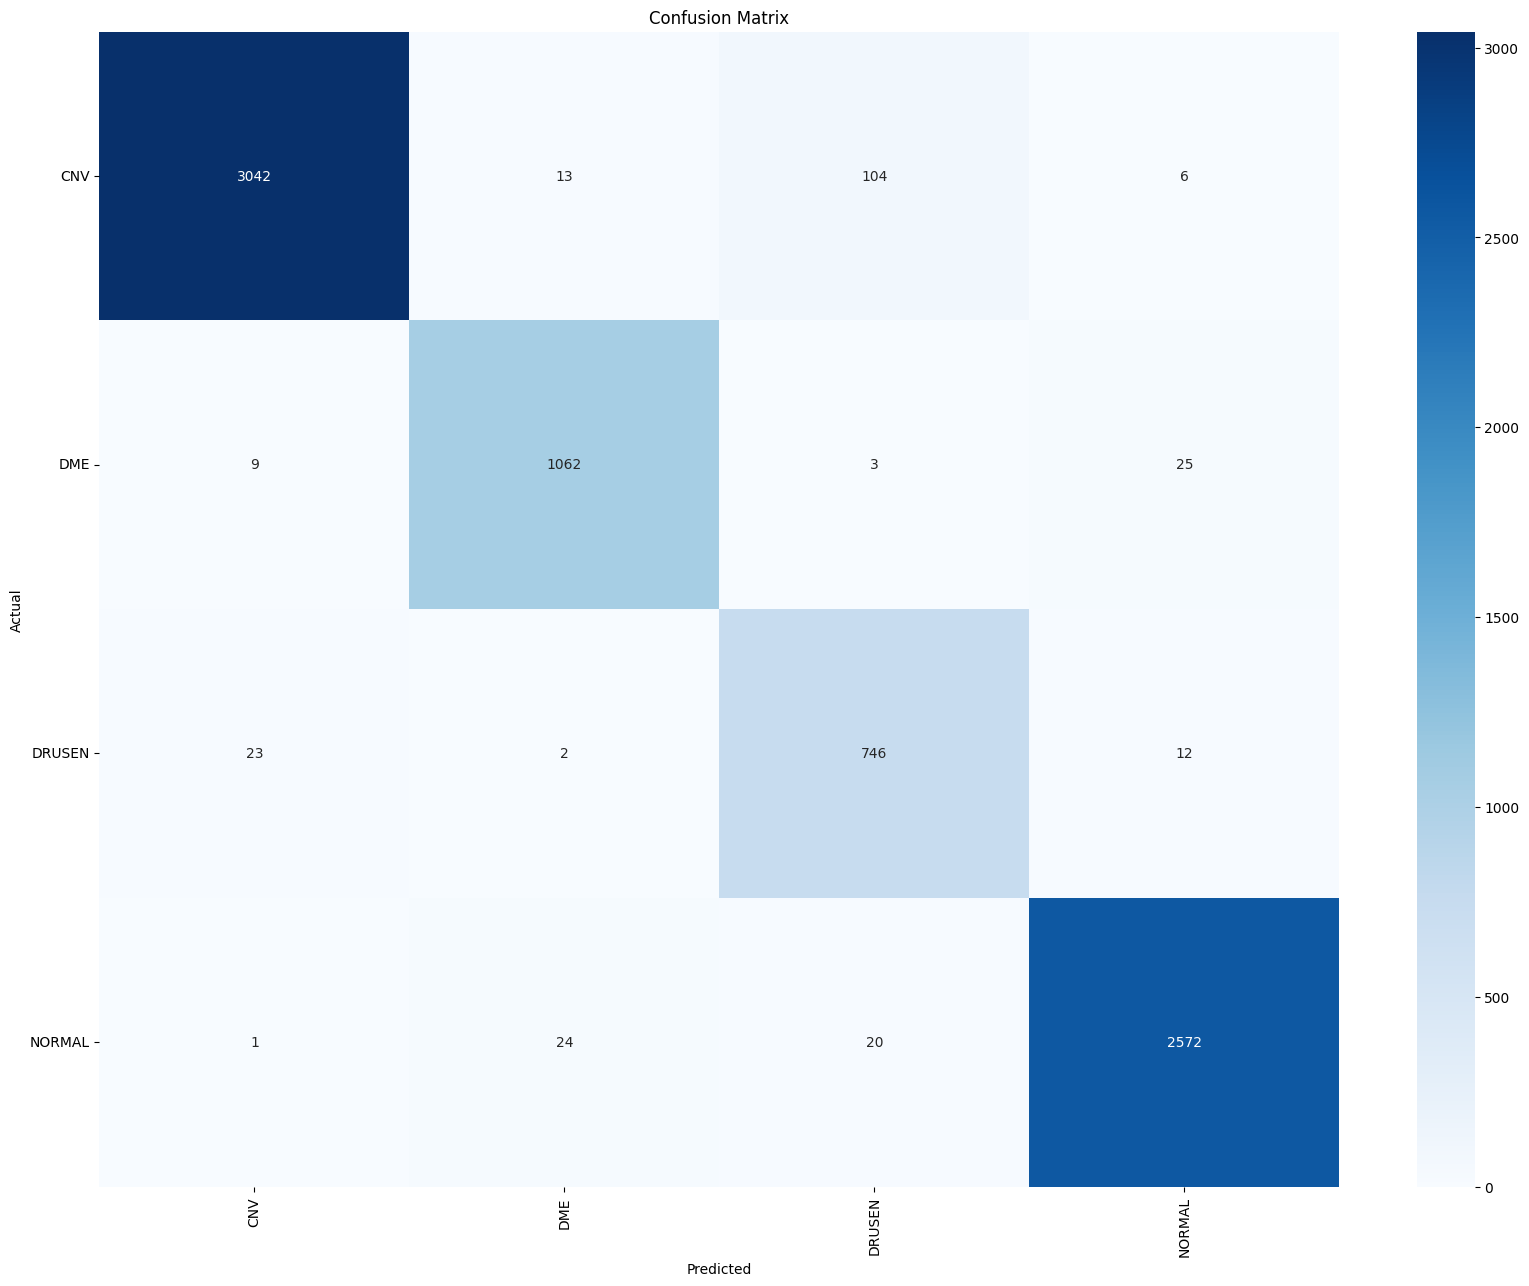

In [ ]:
cm = confusion_matrix(y, pred2)

plt.figure(figsize=(20, 15))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')

num_classes = len(classes)

plt.xticks(ticks=[i + 0.5 for i in range(num_classes)], labels=classes, rotation=90)
plt.yticks(ticks=[i + 0.5 for i in range(num_classes)], labels=classes, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

plt.show()

##FDR control

I chose class ‘Normal’ as negative and others as positives. Then, I used Benjamini-Hochberg protocol (BHP) with empirical p-values (EPV) to construct the dependence between the number of accepted discoveries and False Discovery Rate assuming that true labels are unknown.

In [ ]:
# Predicted positive: 5049
# False positive: 45
# False Discovery Rate: 0.9%

In [ ]:
from bisect import bisect
def calculate_fdr(scores, labels):
    sort_data = torch.sort(scores, descending=True)
    sorted_test_labels = labels[sort_data[1].data.cpu().numpy()]

    negative = 0
    positive = 0
    fdr = []
    for label in sorted_test_labels:
        negative += label.item() == 0
        positive += label.item() == 1
        fdr.append(negative / (negative + positive))
    return np.array(fdr)


def calculate_qvalues_from_labels(scores, labels):
    qvalue = calculate_fdr(scores, labels)
    for i in range(len(qvalue) - 1, 0, -1):
        qvalue[i - 1] = min(qvalue[i], qvalue[i - 1])
    return qvalue

def empirical_p_values(distribution, query):  # distribution - sorted list, query - list
    dist_len = len(distribution)
    query_len = len(query)
    p_values = np.zeros([query_len, ])

    for i, score in enumerate(query):
        p_values[i] = (dist_len - bisect(distribution, score)) / dist_len
    return np.sort(p_values)

def calculate_qvalues_from_pvalues(distribution, query, pi_0=0.9):
    p_values = empirical_p_values(np.sort(distribution), query)
    q_values = p_values * len(p_values) * pi_0
    q_values = q_values / np.arange(1, len(p_values) + 1)
    for i in range(len(p_values) - 1, 0, -1):
        q_values[i - 1] = min(q_values[i - 1], q_values[i])

    return q_values

In [ ]:
model = tf.keras.models.load_model('C:/Users/User/Downloads/Retinal/ModelDist_36.keras')

In [ ]:
x_test = np.load('C:/Users/User/Downloads/Retinal/x_test.npy')
y_test = np.load('C:/Users/User/Downloads/Retinal/y_test.npy')
batch_size = 16
gen = ImageDataGenerator()
ts_gen = gen.flow(x_test, y_test, batch_size=batch_size, shuffle=False)
collect()

311

In [ ]:
import tqdm
scores = torch.tensor([])
labels = torch.tensor([])
counter = 0
for data in tqdm.tqdm(ts_gen):
    if counter == 479:
        break
    counter += 1
    res = model(data[0])
    res = 1 - torch.tensor(np.array(res))[:,0]
    y = 1 - torch.tensor(np.array(data[1]))[:,0]
    scores = torch.cat((scores,res))
    labels = torch.cat((labels,y))

100%|████████████████████████████████████████████████████████████████████████████████| 479/479 [12:31<00:00,  1.57s/it]


In [ ]:
scores.shape, labels.shape

(torch.Size([7664]), torch.Size([7664]))

In [ ]:
# savetxt('scores.csv', scores.detach(), delimiter=',')
# savetxt('labels.csv', labels.detach(), delimiter=',')

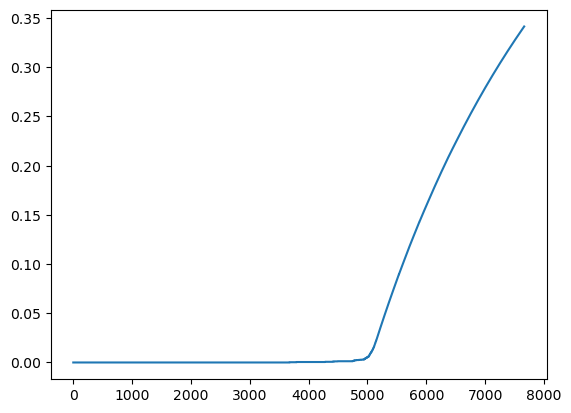

In [ ]:
fdr = calculate_fdr(scores, labels)
qvalues = calculate_qvalues_from_labels(scores, labels)
plt.plot(qvalues)

In [ ]:
test_classes_dist = [0]*4
counter = 0
for data in tqdm.tqdm(ts_gen):
    if counter == 479:
        break
    counter += 1
    ls = np.array(model(data[0])).argmax(axis=1)
    for i in ls:
        test_classes_dist[i]+=1
test_classes_dist

100%|████████████████████████████████████████████████████████████████████████████████| 479/479 [12:16<00:00,  1.54s/it]


[2615, 873, 1101, 3075]

In [ ]:
#Consider NORMAL to be negative class
pi_0 = test_classes_dist[0] / sum(test_classes_dist) # 2615/7664
pi_0

0.341205636743215

In [ ]:
batch_size = 16
gen = ImageDataGenerator()

for idx in range(1, 7):
    x_train = np.load('C:/Users/User/Downloads/Retinal_train/x_train{}.npy'.format(idx))
    y_train = np.load('C:/Users/User/Downloads/Retinal_train/y_train{}.npy'.format(idx))
    tr_gen = gen.flow(x_train, y_train, batch_size=batch_size)
    collect()

    train_scores_n = torch.tensor([])
    train_scores_p = torch.tensor([])
    counter = 0
    for data in tqdm.tqdm(tr_gen):
        if counter == 250:
            break
        counter += 1
        res = model(data[0])
        res = 1 - torch.tensor(np.array(res))[:,0]
        y = 1 - torch.tensor(np.array(data[1]))[:,0]
        train_scores_n = torch.cat((train_scores_n,res[y == 0]))
        train_scores_p = torch.cat((train_scores_p,res[y == 1]))
    collect()
    savetxt('train_scores_n_{}.csv'.format(idx), train_scores_n.detach(), delimiter=',')
    savetxt('train_scores_p_{}.csv'.format(idx), train_scores_p.detach(), delimiter=',')

100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [08:38<00:00,  2.07s/it]


In [ ]:
train_scores_n = torch.tensor([])
train_scores_p = torch.tensor([])
for idx in range(1, 7):
    train_scores_n_part = torch.tensor(genfromtxt('train_scores_n_{}.csv'.format(idx), delimiter=','))
    train_scores_p_part = torch.tensor(genfromtxt('train_scores_p_{}.csv'.format(idx), delimiter=','))
    train_scores_n = torch.cat((train_scores_n, train_scores_n_part))
    train_scores_p = torch.cat((train_scores_p, train_scores_p_part))
savetxt('train_scores_n.csv', train_scores_n, delimiter=',')
savetxt('train_scores_p.csv', train_scores_p, delimiter=',')
train_scores_n.shape, train_scores_p.shape

(torch.Size([6000]), torch.Size([18000]))

In [ ]:
scores = torch.tensor(genfromtxt('scores.csv', delimiter=','))
labels = torch.tensor(genfromtxt('labels.csv', delimiter=','))
train_scores_n = torch.tensor(genfromtxt('train_scores_n.csv', delimiter=','))
train_scores_p = torch.tensor(genfromtxt('train_scores_p.csv', delimiter=','))
scores.shape, labels.shape, train_scores_n.shape, train_scores_p.shape

(torch.Size([7664]),
 torch.Size([7664]),
 torch.Size([6000]),
 torch.Size([18000]))

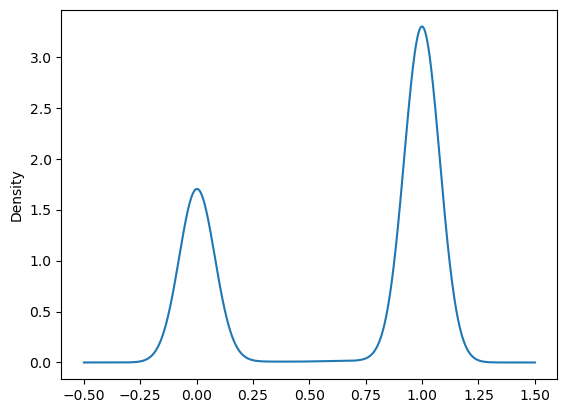

In [ ]:
prob = pd.Series(scores).plot.kde().get_lines()[0].get_xydata()[300:700]

In [ ]:
mid = min(prob, key=lambda x: x[1])
prob[0], mid, prob[-1]

(array([0.1006006 , 0.78204974]),
 array([0.3968969 , 0.00838204]),
 array([0.8993994 , 1.48901512]))

In [ ]:
scores_n = scores[scores <= mid[0]]
scores_p = scores[scores > mid[0]]
scores_n.shape, scores_p.shape

(torch.Size([2611]), torch.Size([5053]))

In [ ]:
m_n_tr = train_scores_n.mean()
std_n_tr = train_scores_n.std()
m_n = scores_n.mean()
std_n = scores_n.std()
m_n_tr.item(), std_n_tr.item(), m_n.item(), std_n.item()

(0.0014399429261684417,
 0.01672183354184148,
 0.0038393007891701354,
 0.025988982514269832)

In [ ]:
m_p_tr = train_scores_p.mean()
m_p = scores_p.mean()
m_p_tr.item(), m_p.item()

(0.9975595628718535, 0.9960268447947884)

In [ ]:
scores_n = scores[scores <= mid[0]]
scores_p = scores[scores > mid[0]]
scores_n.shape, scores_p.shape

(torch.Size([2611]), torch.Size([5053]))

In [ ]:
scores_n = (scores_n - m_n) / std_n * std_n_tr + m_n_tr
scores_p = scores_p - m_p + m_p_tr
scores = torch.cat((scores_n, scores_p))

In [ ]:
eqv = calculate_qvalues_from_pvalues(train_scores_n, scores, pi_0)

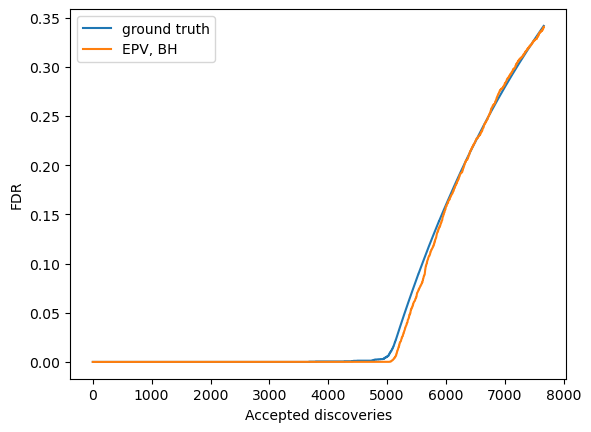

In [ ]:
plt.plot(qvalues, label='ground truth')
plt.plot(eqv, label='EPV, BH')
plt.xlabel("Accepted discoveries")
plt.ylabel("FDR")
plt.legend()

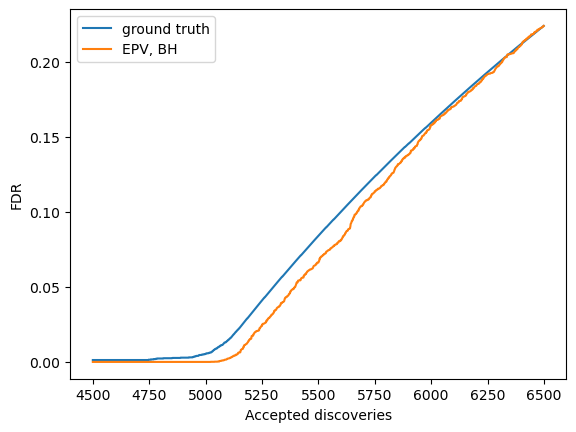

In [ ]:
plt.plot(range(4500, 6500), qvalues[4500:6500], label='ground truth')
plt.plot(range(4500, 6500), eqv[4500:6500], label='EPV, BH')
plt.xlabel("Accepted discoveries")
plt.ylabel("FDR")
plt.legend()

##End